In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
import time

In [3]:
import os
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/')
import triplet

### Get Data

In [4]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [5]:
def front_or_back(img_path, train=True):
    DATA_ROOT = '/home/albert/caffe/'
    
    if img_path.find('/') > -1:
        root = img_path[len(img_path) - img_path[::-1].index('/'):-4:]
    else:
        root = img_path[0:img_path.index('.')]

    if train:
        keypoint_path = DATA_ROOT + 'data/market-1501/train_openpose/train_keypoints/%s_keypoints.json' % root
    else:
        keypoint_path = DATA_ROOT + 'data/market-1501/test_openpose/test_keypoints/%s_keypoints.json' % root
    
    with open(keypoint_path) as data_file:
        data = json.load(data_file)
    
    keypoints = []
    
    for person in range(len(data['people'])):
        keypoints.append({'x' : [], 'y' : [], 'c' : []})
        for i in range(0, len(data['people'][person]['pose_keypoints']), 3):
            x_key = data['people'][person]['pose_keypoints'][i]
            y_key = data['people'][person]['pose_keypoints'][i + 1]
            c_key = data['people'][person]['pose_keypoints'][i + 2]
            
            keypoints[person]['x'].append(x_key)
            keypoints[person]['y'].append(y_key)
            keypoints[person]['c'].append(c_key)
    
    for person in range(len(keypoints)):
        if keypoints[person]['x'][2] < keypoints[person]['x'][5]:
            return 'front'
        else:
            return 'back'

In [6]:
front_train_dict = {}
front_train_files = []
front_train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        if front_or_back(path, train=True) == 'front':
            idt = int(f[0:f.index('_')])
            if not any(idt == l for l in front_train_labels):
                front_train_labels.append(idt)
                front_train_dict[idt] = []

            front_train_files.append([path, idt])
            front_train_dict[idt].append(path)

front_train_labels.sort()

front_test_dict = {}
front_test_files = []
front_test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
        if front_or_back(path, train=False) == 'front':
            idt = int(f[0:f.index('_')])
            if idt != 0 and idt != -1:
                if not any(idt == l for l in front_test_labels):
                    front_test_labels.append(idt)
                    front_test_dict[idt] = []

                front_test_files.append([path, idt])
                front_test_dict[idt].append(path)

front_test_labels.sort()

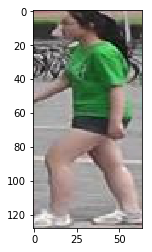

In [7]:
plt.imshow(misc.imread(front_test_files[3][0]))

In [8]:
back_train_dict = {}
back_train_files = []
back_train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        if front_or_back(path, train=True) == 'back':
            idt = int(f[0:f.index('_')])
            if not any(idt == l for l in back_train_labels):
                back_train_labels.append(idt)
                back_train_dict[idt] = []

            back_train_files.append([path, idt])
            back_train_dict[idt].append(path)

back_train_labels.sort()

back_test_dict = {}
back_test_files = []
back_test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
        if front_or_back(path, train=False) == 'back':
            idt = int(f[0:f.index('_')])
            if idt != 0 and idt != -1:
                if not any(idt == l for l in back_test_labels):
                    back_test_labels.append(idt)
                    back_test_dict[idt] = []

                back_test_files.append([path, idt])
                back_test_dict[idt].append(path)

back_test_labels.sort()

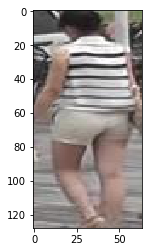

In [9]:
plt.imshow(misc.imread(back_test_files[1][0]))

False
True
0.801034927368


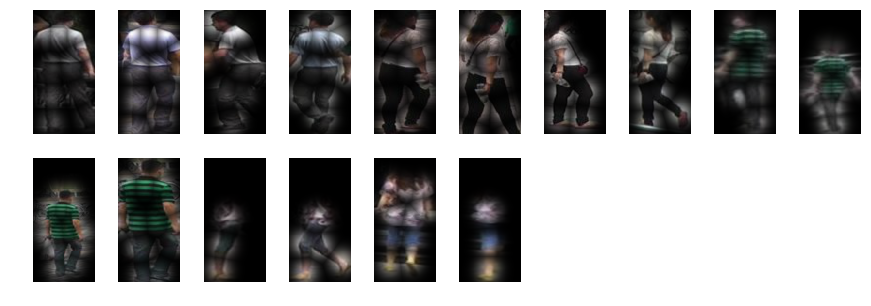

In [10]:
start = time.time()
batch = triplet.output_batch_generator(back_train_dict, back_train_labels, overlay=True, preprocess=False, 
                                                        shape=(256,128)).next()
print time.time() - start

plt.figure(figsize=(15,5))
for i in range(16):
    plt.subplot(2,10,i+1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.axis('off')
plt.show()

### Train Network

In [11]:
steps_per_epoch = 100

input_shape = (256,128)

overlay = False
overlay_eval = False
preprocess = True

In [12]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

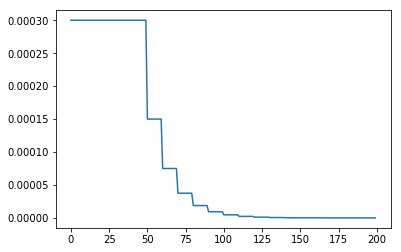

In [13]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [14]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

### Evaluation

In [15]:
# model = load_model('/home/albert/github/tensorflow/models/densenet_triplet_front_256x128/densenet_triplet_front_256x128_15000.h5', 
#                    custom_objects={'triplet_loss' : triplet.triplet_loss})

In [16]:
front_train_dict_2 = {}
front_train_files_2 = []

idt_at_least_2 = []

for idt in front_train_dict.keys():
    if len(front_train_dict[idt]) > 1:
        idt_at_least_2.append(idt)
        front_train_dict_2[idt] = front_train_dict[idt]

for f in front_train_files:
    try:
        x = idt_at_least_2.index(f[1])
        front_train_files_2.append(f)
    except ValueError:
        pass

In [17]:
front_test_dict_2 = {}
front_test_files_2 = []

idt_at_least_2_2 = []

for idt in front_test_dict.keys():
    if len(front_test_dict[idt]) > 1:
        idt_at_least_2_2.append(idt)
        front_test_dict_2[idt] = front_test_dict[idt]

for f in front_test_files:
    try:
        x = idt_at_least_2_2.index(f[1])
        front_test_files_2.append(f)
    except ValueError:
        pass

Weights for the model were loaded successfully
True
False
Epoch 1/10
100/100 [==============================] - 64s - loss: 221.1625    
Epoch 2/10
100/100 [==============================] - 59s - loss: 147.4608    
Epoch 3/10
100/100 [==============================] - 61s - loss: 128.0140    
Epoch 4/10
100/100 [==============================] - 60s - loss: 91.3770    
Epoch 5/10
100/100 [==============================] - 61s - loss: 72.2733    
Epoch 6/10
100/100 [==============================] - 60s - loss: 69.3012    
Epoch 7/10
100/100 [==============================] - 60s - loss: 75.2481    
Epoch 8/10
100/100 [==============================] - 60s - loss: 67.2349    
Epoch 9/10
100/100 [==============================] - 60s - loss: 59.0924    
Epoch 10/10
100/100 [==============================] - 60s - loss: 54.8888    
preprocess True
overlay False
train True
1000 21.2073981762
2000 40.9403700829
3000 60.6212949753
4000 80.2738370895
5000 99.9269840717
6000 119.668323994


/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/albert/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in true_divide
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train 1000


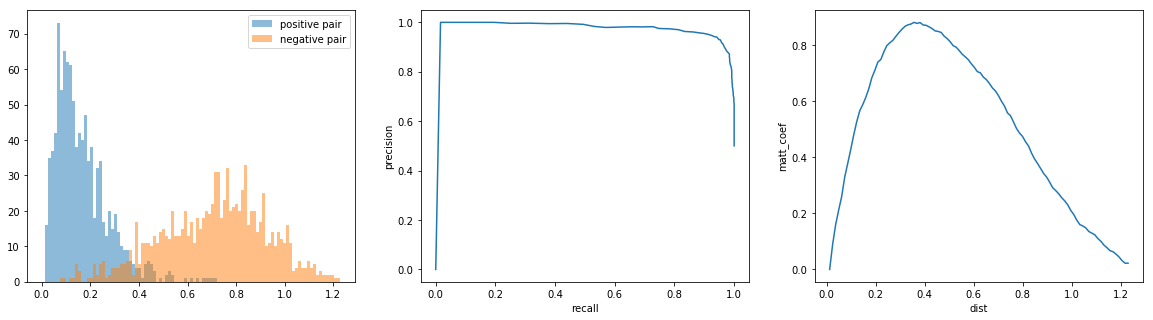

{1: 0.7456666666666667, 20: 0.95033333333333336, 5: 0.879}
preprocess True
overlay False
train False
1000 19.6369948387
2000 39.3047950268
3000 58.9789788723
4000 78.6299088001
5000 98.284142971
6000 117.954716921
7000 137.617811918
test 1000


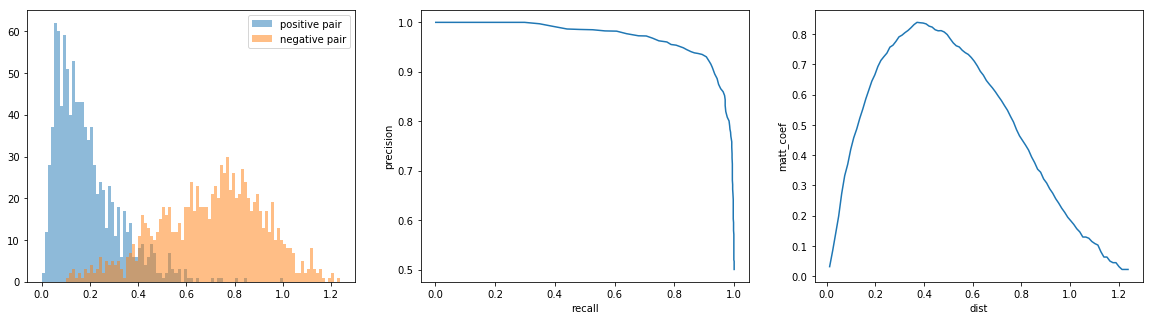

{1: 0.72033333333333338, 20: 0.93933333333333324, 5: 0.8756666666666667}
True
False
Epoch 1/10
100/100 [==============================] - 62s - loss: 60.1893    
Epoch 2/10
100/100 [==============================] - 57s - loss: 49.4669    
Epoch 3/10
100/100 [==============================] - 58s - loss: 59.4780    
Epoch 4/10
100/100 [==============================] - 57s - loss: 45.7443    
Epoch 5/10
100/100 [==============================] - 58s - loss: 45.5167    
Epoch 6/10
100/100 [==============================] - 57s - loss: 52.5460    
Epoch 7/10
100/100 [==============================] - 57s - loss: 44.2413    
Epoch 8/10
100/100 [==============================] - 59s - loss: 49.7595    
Epoch 9/10
100/100 [==============================] - 58s - loss: 66.1502    
Epoch 10/10
100/100 [==============================] - 58s - loss: 49.9991    
preprocess True
overlay False
train True
1000 19.5767378807
2000 39.1476929188
3000 58.7272670269
4000 78.3063669205
5000 97.8428430557

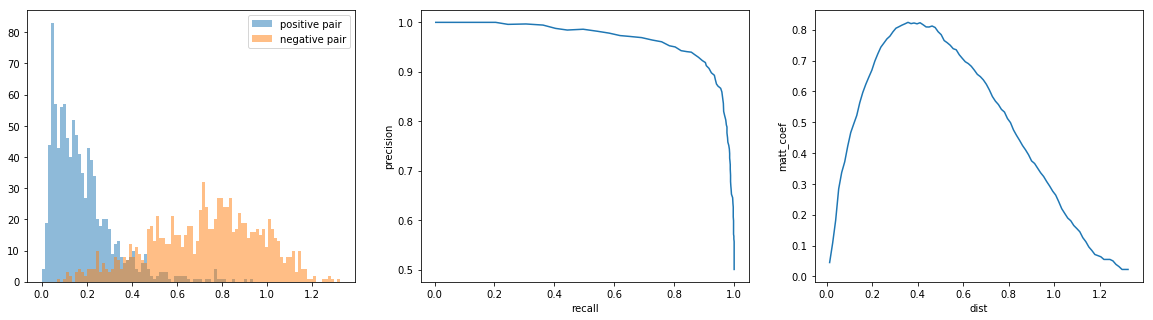

{1: 0.67933333333333346, 20: 0.93500000000000005, 5: 0.84699999999999998}
preprocess True
overlay False
train False
1000 19.5717589855
2000 39.0905709267
3000 58.59207201
4000 78.1181690693
5000 97.7092900276
6000 117.268730879
7000 136.796175003
test 2000


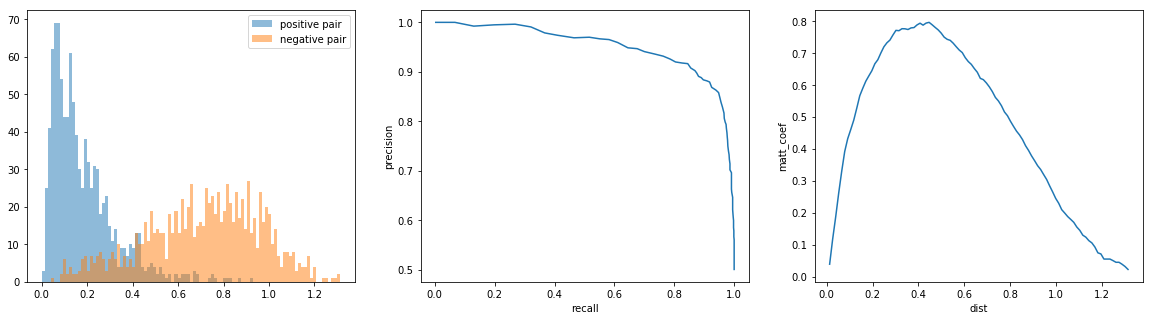

{1: 0.63900000000000001, 20: 0.92300000000000004, 5: 0.82999999999999996}True

FalseEpoch 1/10

100/100 [==============================] - 63s - loss: 49.0708    
Epoch 2/10
100/100 [==============================] - 57s - loss: 35.3225    
Epoch 3/10
100/100 [==============================] - 57s - loss: 46.8431    
Epoch 4/10
100/100 [==============================] - 58s - loss: 51.1371    
Epoch 5/10
100/100 [==============================] - 58s - loss: 33.8772    
Epoch 6/10
100/100 [==============================] - 57s - loss: 36.4464    
Epoch 7/10
100/100 [==============================] - 57s - loss: 42.9662    
Epoch 8/10
100/100 [==============================] - 57s - loss: 43.4162    
Epoch 9/10
100/100 [==============================] - 57s - loss: 33.2354    
Epoch 10/10
100/100 [==============================] - 57s - loss: 31.6145    
preprocess True
overlay False
train True
1000 19.6491250992
2000 39.27206707
3000 58.8878569603
4000 78.5048129559
5000 98.1403579712


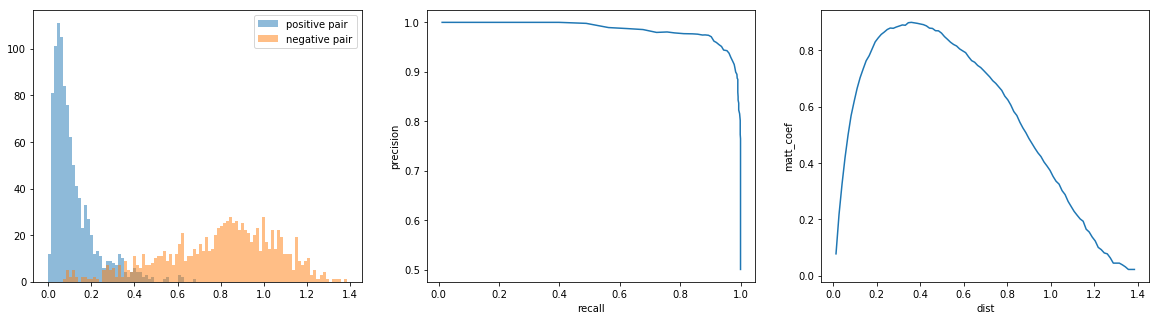

{1: 0.75, 20: 0.96666666666666667, 5: 0.90066666666666662}
preprocess True
overlay False
train False
1000 19.5657958984
2000 39.1144478321
3000 58.6640949249
4000 78.2316470146
5000 97.8028838634
6000 117.324609041
7000 136.8916049
test 3000


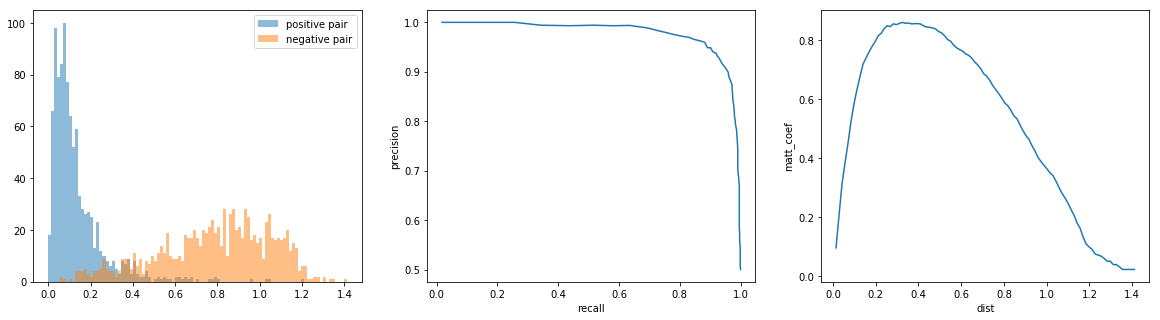

{1: 0.71166666666666656, 20: 0.95133333333333336, 5: 0.874}
True
False
Epoch 1/10
100/100 [==============================] - 62s - loss: 50.5579    
Epoch 2/10
100/100 [==============================] - 57s - loss: 33.6872    
Epoch 3/10
100/100 [==============================] - 57s - loss: 31.6686    
Epoch 4/10
100/100 [==============================] - 57s - loss: 47.7514    
Epoch 5/10
100/100 [==============================] - 58s - loss: 42.1307    
Epoch 6/10
100/100 [==============================] - 57s - loss: 35.4651    
Epoch 7/10
100/100 [==============================] - 58s - loss: 37.1734    
Epoch 8/10
100/100 [==============================] - 58s - loss: 36.8856    
Epoch 9/10
100/100 [==============================] - 57s - loss: 37.1423    
Epoch 10/10
100/100 [==============================] - 58s - loss: 36.1713    
preprocess True
overlay False
train True
1000 19.6253409386
2000 39.1983208656
3000 58.7743480206
4000 78.3821618557
5000 97.9964709282
6000 117.628

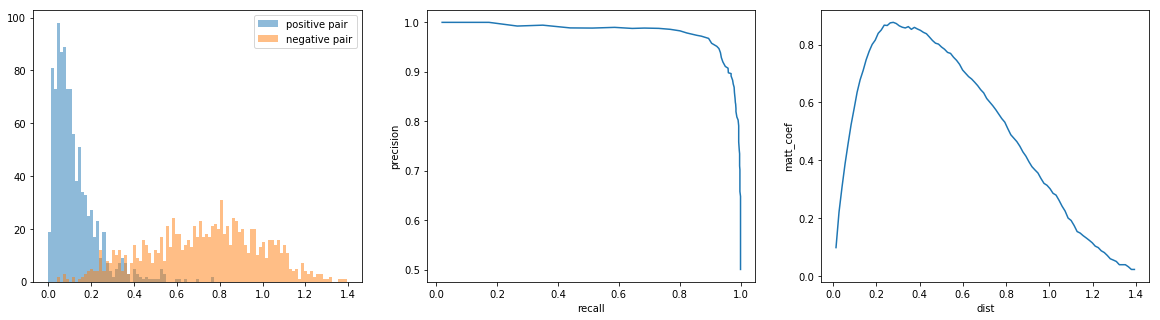

{1: 0.75599999999999989, 20: 0.96633333333333338, 5: 0.89866666666666661}
preprocess True
overlay False
train False
1000 19.5457828045
2000 39.0672838688
3000 58.5604808331
4000 78.0911829472
5000 97.5910258293
6000 117.238529921
7000 136.761518955
test 4000


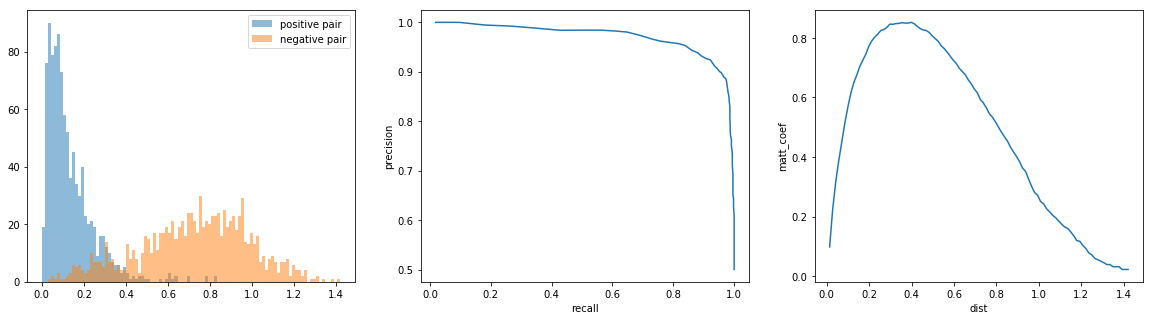

{1: 0.72066666666666668, 20: 0.94699999999999995, 5: 0.88233333333333341}
True
False
Epoch 1/10
100/100 [==============================] - 63s - loss: 25.6014    
Epoch 2/10
100/100 [==============================] - 59s - loss: 42.1167    
Epoch 3/10
100/100 [==============================] - 59s - loss: 53.6737    
Epoch 4/10
100/100 [==============================] - 59s - loss: 32.7040    
Epoch 5/10
100/100 [==============================] - 59s - loss: 22.4387    
Epoch 6/10
100/100 [==============================] - 59s - loss: 36.1708    
Epoch 7/10
100/100 [==============================] - 59s - loss: 40.1645    
Epoch 8/10
100/100 [==============================] - 59s - loss: 28.5422    
Epoch 9/10
100/100 [==============================] - 59s - loss: 28.8377    
Epoch 10/10
100/100 [==============================] - 59s - loss: 30.6119    
preprocess True
overlay False
train True
1000 19.5785470009
2000 39.1219320297
3000 58.6726021767
4000 78.2041032314
5000 97.729931116

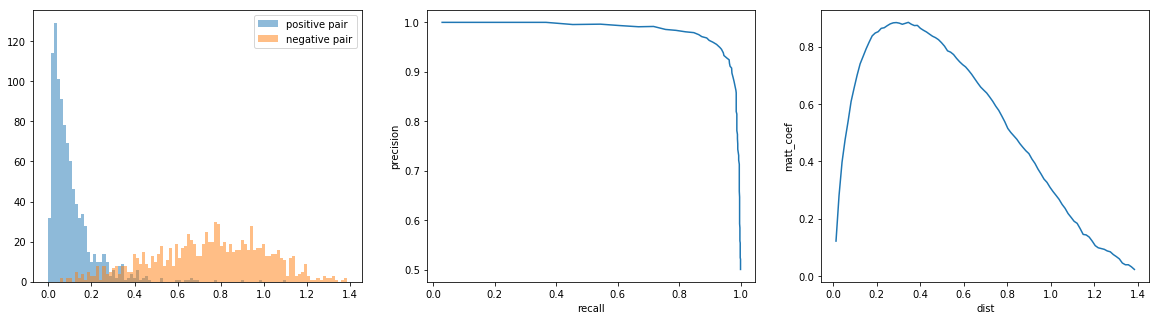

{1: 0.75700000000000001, 20: 0.96399999999999997, 5: 0.90133333333333321}
preprocess True
overlay False
train False
1000 19.5383620262
2000 39.0708329678
3000 58.6333639622
4000 78.1730000973
5000 97.7094140053
6000 117.277053118
7000 136.828483105
test 5000


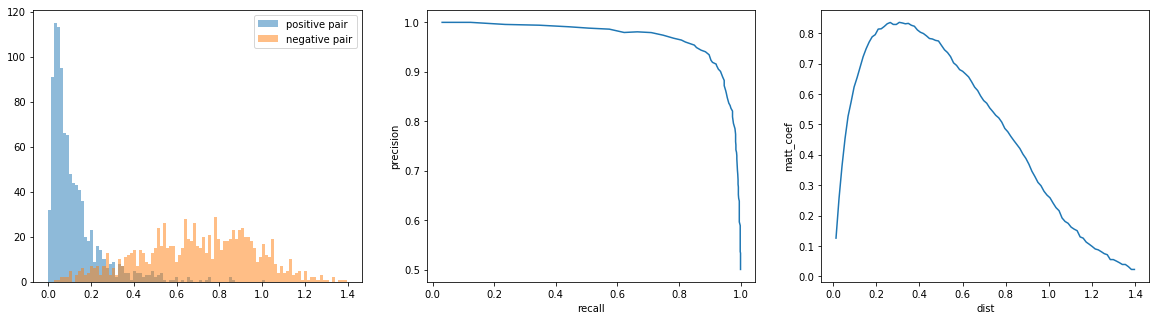

{1: 0.69966666666666677, 20: 0.94999999999999984, 5: 0.88300000000000001}
True
False
Epoch 1/10
100/100 [==============================] - 62s - loss: 33.6640    
Epoch 2/10
100/100 [==============================] - 57s - loss: 13.6577    
Epoch 3/10
100/100 [==============================] - 58s - loss: 16.7532    
Epoch 4/10
100/100 [==============================] - 57s - loss: 12.8290    
Epoch 5/10
100/100 [==============================] - 57s - loss: 13.9567    
Epoch 6/10
100/100 [==============================] - 58s - loss: 11.3505    
Epoch 7/10
100/100 [==============================] - 57s - loss: 18.6944    
Epoch 8/10
100/100 [==============================] - 58s - loss: 12.1295    
Epoch 9/10
100/100 [==============================] - 57s - loss: 10.9832    
Epoch 10/10
100/100 [==============================] - 57s - loss: 15.8327    
preprocess True
overlay False
train True
1000 19.5650250912
2000 39.1518449783
3000 58.7078049183
4000 78.2417209148
5000 97.798536062

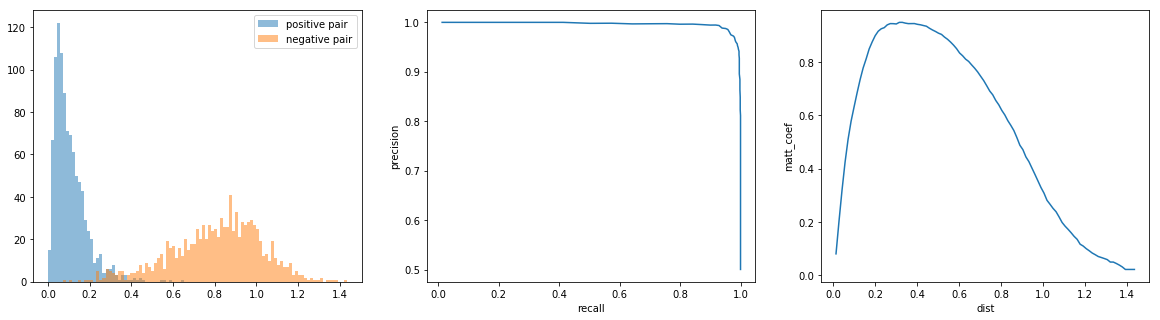

{1: 0.84466666666666657, 20: 0.98666666666666669, 5: 0.95533333333333326}
preprocess True
overlay False
train False
1000 19.5225758553
2000 39.0724430084
3000 58.623734951
4000 78.1568548679
5000 97.7139949799
6000 117.249137878
7000 136.821285963
test 6000


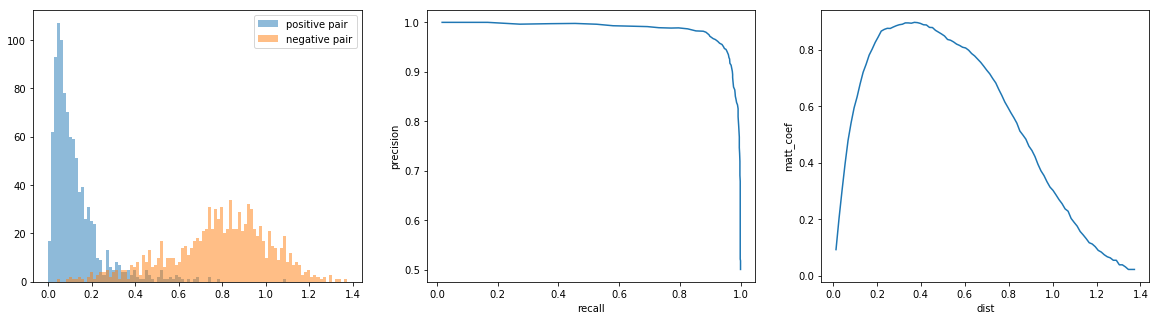

{1: 0.80600000000000005, 20: 0.97499999999999998, 5: 0.92700000000000005}
True
False
Epoch 1/10
100/100 [==============================] - 62s - loss: 12.0083    
Epoch 2/10
100/100 [==============================] - 57s - loss: 10.4994    
Epoch 3/10
100/100 [==============================] - 57s - loss: 5.9037    
Epoch 4/10
100/100 [==============================] - 58s - loss: 11.2598    
Epoch 5/10
100/100 [==============================] - 57s - loss: 10.4410    
Epoch 6/10
100/100 [==============================] - 57s - loss: 5.8622    
Epoch 7/10
100/100 [==============================] - 57s - loss: 11.3980    
Epoch 8/10
100/100 [==============================] - 57s - loss: 6.7608    
Epoch 9/10
100/100 [==============================] - 57s - loss: 7.7765    
Epoch 10/10
100/100 [==============================] - 58s - loss: 8.4315    
preprocess True
overlay False
train True
1000 19.5926849842
2000 39.2111330032
3000 58.8063769341
4000 78.3966488838
5000 98.0044238567
600

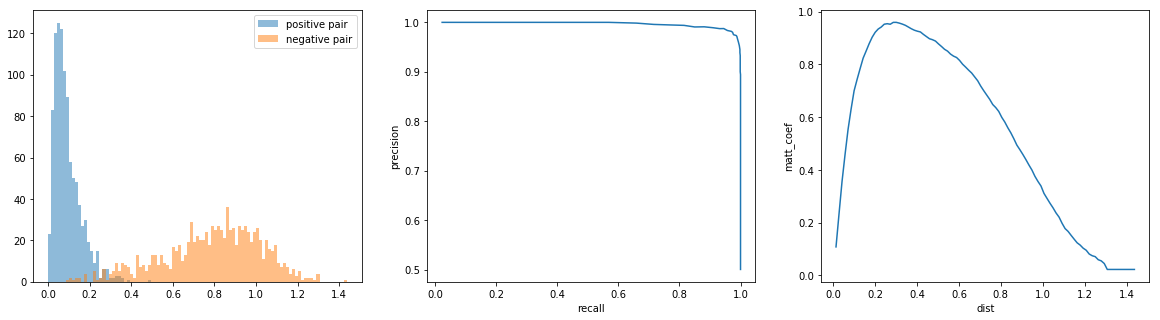

{1: 0.8793333333333333, 20: 0.99366666666666659, 5: 0.97266666666666668}
preprocess True
overlay False
train False
1000 19.5592501163
2000 39.0910670757
3000 58.6291530132
4000 78.1918561459
5000 97.7235450745
6000 117.243089199
7000 136.78720212
test 7000


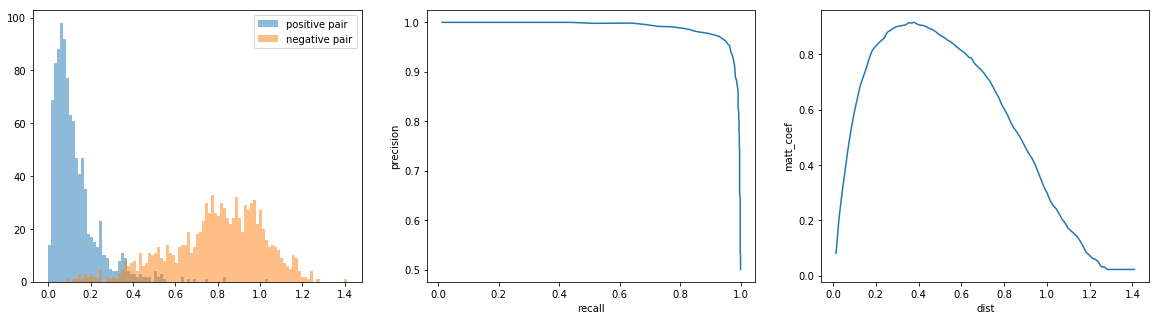

{1: 0.82333333333333325, 20: 0.97966666666666669, 5: 0.94499999999999995}
True
False
Epoch 1/10
100/100 [==============================] - 61s - loss: 7.5222    
Epoch 2/10
100/100 [==============================] - 57s - loss: 10.3277    
Epoch 3/10
100/100 [==============================] - 57s - loss: 7.5037    
Epoch 4/10
100/100 [==============================] - 57s - loss: 4.9247    
Epoch 5/10
100/100 [==============================] - 58s - loss: 4.9056    
Epoch 6/10
100/100 [==============================] - 57s - loss: 4.4236    
Epoch 7/10
100/100 [==============================] - 58s - loss: 7.2133    
Epoch 8/10
100/100 [==============================] - 57s - loss: 7.6257    
Epoch 9/10
100/100 [==============================] - 57s - loss: 7.9176    
Epoch 10/10
100/100 [==============================] - 58s - loss: 6.4481    
preprocess True
overlay False
train True
1000 19.5608460903
2000 39.1243948936
3000 58.6908450127
4000 78.2354650497
5000 97.7727530003
6000 11

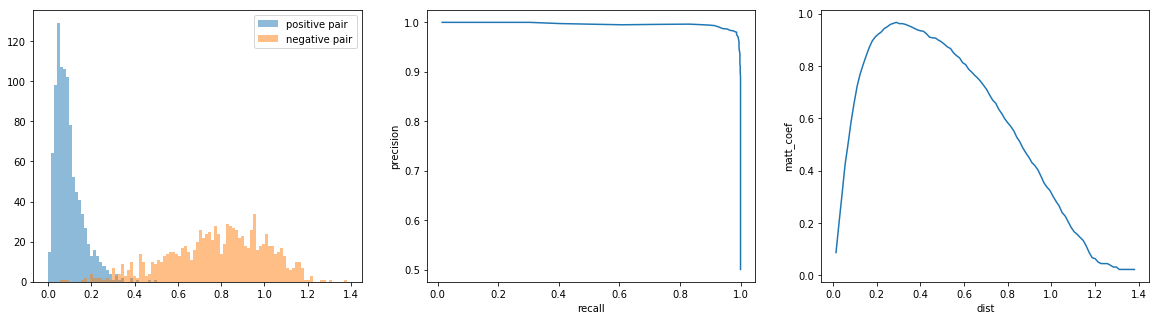

{1: 0.88500000000000012, 20: 0.99733333333333329, 5: 0.97299999999999986}
preprocess True
overlay False
train False
1000 19.5450248718
2000 39.0949468613
3000 58.5905239582
4000 78.1273269653
5000 97.6658289433
6000 117.213363886
7000 136.755568027
test 8000


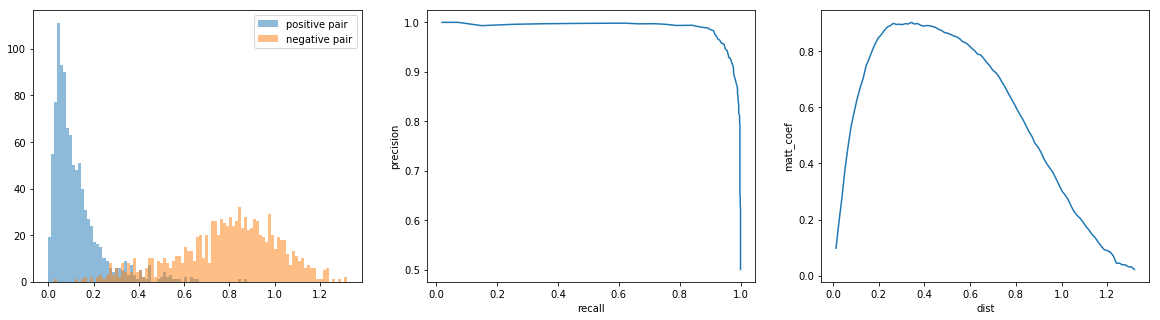

{1: 0.83199999999999996, 20: 0.97799999999999987, 5: 0.93166666666666664}
TrueEpoch 1/10

False
100/100 [==============================] - 63s - loss: 5.2883    
Epoch 2/10
100/100 [==============================] - 59s - loss: 4.9899    
Epoch 3/10
100/100 [==============================] - 59s - loss: 8.2104    
Epoch 4/10
100/100 [==============================] - 59s - loss: 4.5617    
Epoch 5/10
100/100 [==============================] - 59s - loss: 5.4531    
Epoch 6/10
100/100 [==============================] - 59s - loss: 4.8122    
Epoch 7/10
100/100 [==============================] - 59s - loss: 4.2869    
Epoch 8/10
100/100 [==============================] - 59s - loss: 5.0334    
Epoch 9/10
100/100 [==============================] - 59s - loss: 3.6653    
Epoch 10/10
100/100 [==============================] - 59s - loss: 3.1014    
preprocess True
overlay False
train True
1000 19.5462150574
2000 39.0897529125
3000 58.6217310429
4000 78.1252200603
5000 97.6649210453
6000 117

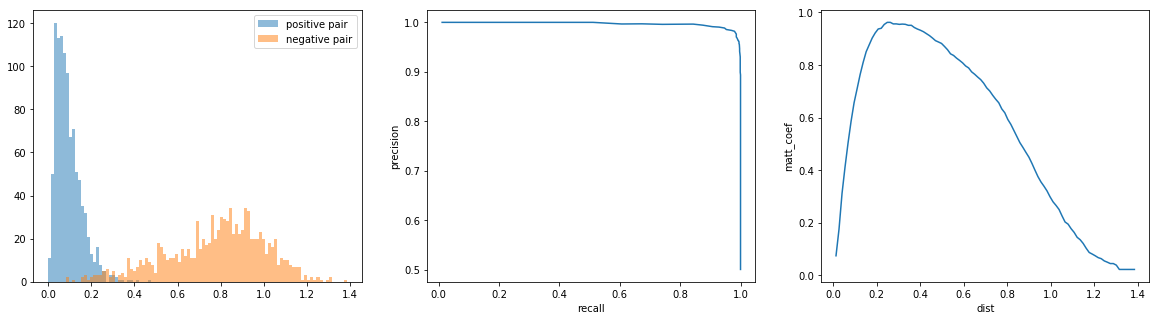

{1: 0.89100000000000001, 20: 0.99733333333333329, 5: 0.98099999999999987}
preprocess True
overlay False
train False
1000 19.518545866
2000 39.0335268974
3000 58.5588798523
4000 78.0504348278
5000 97.5564219952
6000 117.061674833
7000 136.569314003
test 9000


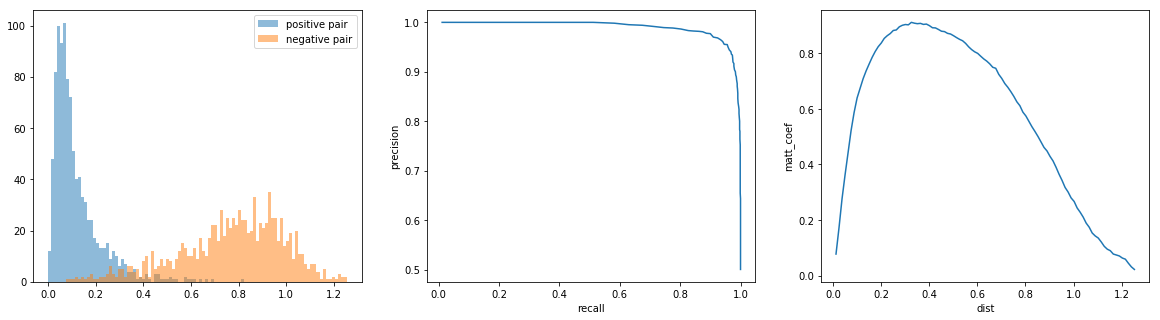

{1: 0.83666666666666656, 20: 0.97533333333333339, 5: 0.93633333333333335}
True
False
Epoch 1/10
100/100 [==============================] - 62s - loss: 6.5522    
Epoch 2/10
100/100 [==============================] - 57s - loss: 4.4334    
Epoch 3/10
100/100 [==============================] - 58s - loss: 3.5079    
Epoch 4/10
100/100 [==============================] - 57s - loss: 5.2156    
Epoch 5/10
100/100 [==============================] - 57s - loss: 4.6231    
Epoch 6/10
100/100 [==============================] - 57s - loss: 3.4240    
Epoch 7/10
100/100 [==============================] - 57s - loss: 4.2784    
Epoch 8/10
100/100 [==============================] - 58s - loss: 5.6794    
Epoch 9/10
100/100 [==============================] - 57s - loss: 4.1386    
Epoch 10/10
100/100 [==============================] - 57s - loss: 6.4561    
preprocess True
overlay False
train True
1000 19.5893588066
2000 39.1888678074
3000 58.7941768169
4000 78.3538069725
5000 97.930038929
6000 117.

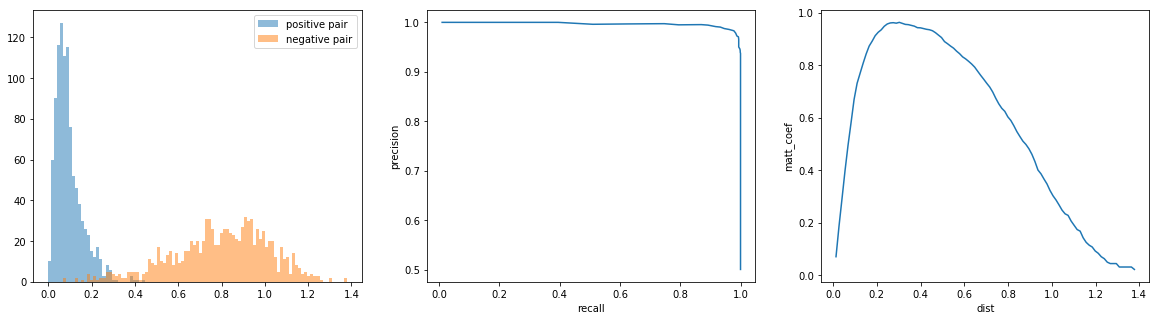

{1: 0.89866666666666661, 20: 0.99533333333333329, 5: 0.98033333333333328}
preprocess True
overlay False
train False
1000 19.5368077755
2000 39.0327379704
3000 58.558839798
4000 78.0550398827
5000 97.6596238613
6000 117.164227962
7000 136.698346853
test 10000


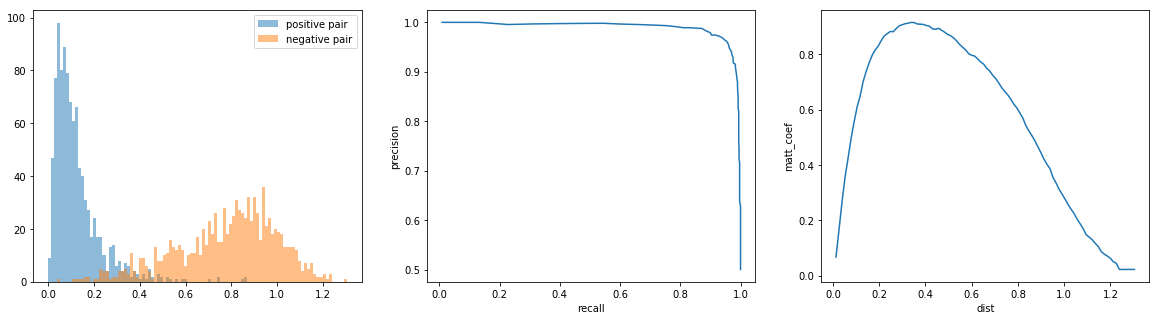

{1: 0.84666666666666668, 20: 0.97966666666666669, 5: 0.94233333333333336}
TrueEpoch 1/10

False
100/100 [==============================] - 62s - loss: 7.2484    
Epoch 2/10
100/100 [==============================] - 57s - loss: 6.2261    
Epoch 3/10
100/100 [==============================] - 57s - loss: 3.7354    
Epoch 4/10
100/100 [==============================] - 57s - loss: 3.6330    
Epoch 5/10
100/100 [==============================] - 57s - loss: 2.4140    
Epoch 6/10
100/100 [==============================] - 58s - loss: 5.5297    
Epoch 7/10
100/100 [==============================] - 57s - loss: 6.4087    
Epoch 8/10
100/100 [==============================] - 58s - loss: 4.7357    
Epoch 9/10
100/100 [==============================] - 57s - loss: 5.2374    
Epoch 10/10
100/100 [==============================] - 58s - loss: 2.7250    
preprocess True
overlay False
train True
1000 19.5876159668
2000 39.2262639999
3000 58.8009200096
4000 78.3731479645
5000 98.0003380775
6000 117

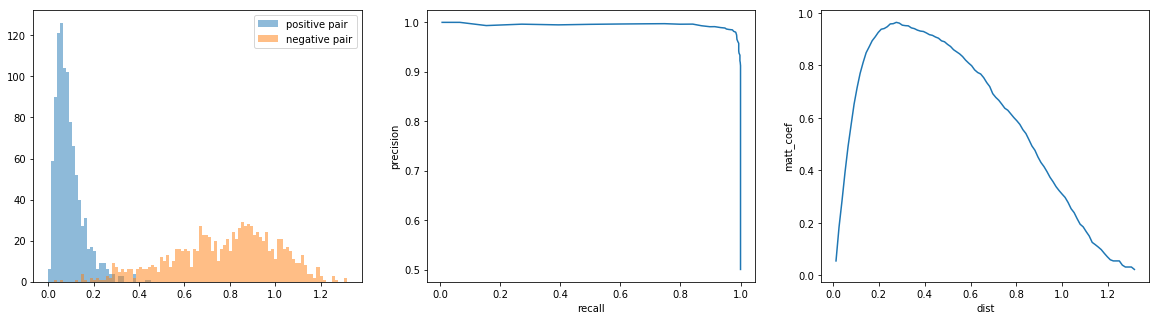

{1: 0.90266666666666673, 20: 0.99733333333333329, 5: 0.98333333333333339}
preprocess True
overlay False
train False
1000 19.5235509872
2000 39.0323970318
3000 58.5479590893
4000 78.087264061
5000 97.6456019878
6000 117.205430031
7000 136.974141121
test 11000


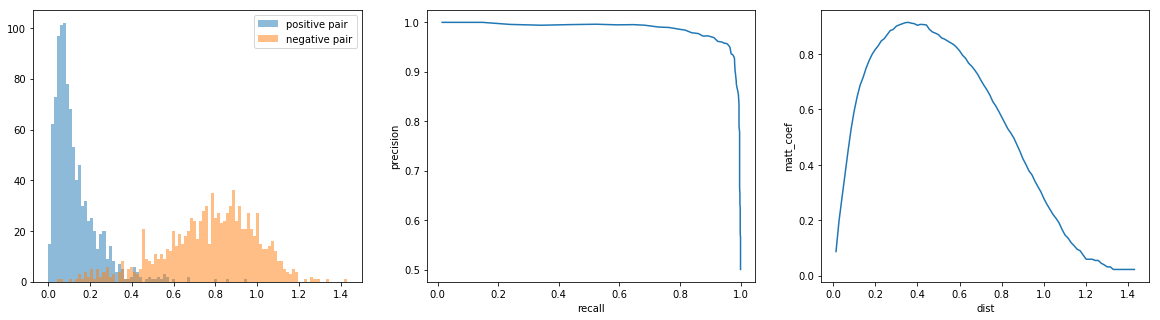

{1: 0.85300000000000009, 20: 0.98099999999999998, 5: 0.94833333333333325}True

False
Epoch 1/10
100/100 [==============================] - 61s - loss: 5.2170    
Epoch 2/10
100/100 [==============================] - 57s - loss: 4.1860    
Epoch 3/10
100/100 [==============================] - 57s - loss: 3.3782    
Epoch 4/10
100/100 [==============================] - 56s - loss: 5.1097    
Epoch 5/10
100/100 [==============================] - 58s - loss: 3.8045    
Epoch 6/10
100/100 [==============================] - 57s - loss: 5.6389    
Epoch 7/10
100/100 [==============================] - 58s - loss: 3.7948    
Epoch 8/10
100/100 [==============================] - 58s - loss: 3.1045    
Epoch 9/10
100/100 [==============================] - 57s - loss: 4.1813    
Epoch 10/10
100/100 [==============================] - 58s - loss: 5.0346    
preprocess True
overlay False
train True
1000 19.5853340626
2000 39.2184841633
3000 58.8918600082
4000 78.4784500599
5000 98.0543420315
6000 117

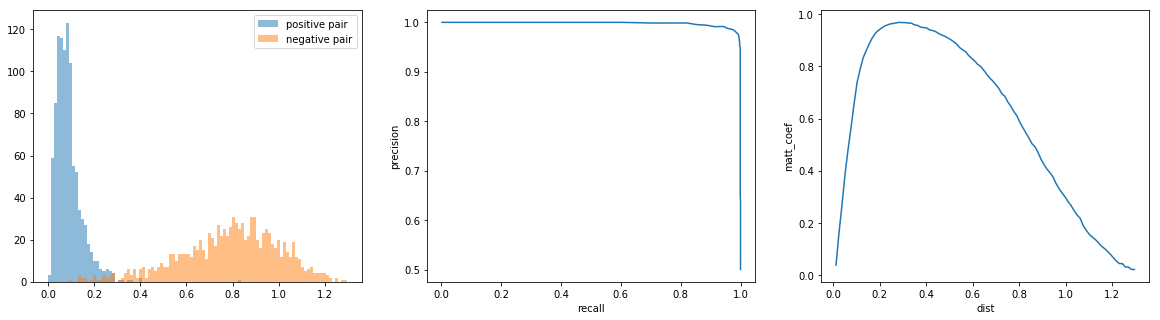

{1: 0.90600000000000003, 20: 0.996, 5: 0.98533333333333328}
preprocess True
overlay False
train False
1000 19.5227971077
2000 39.0421590805
3000 58.5694000721
4000 78.0925331116
5000 97.5983271599
6000 117.133718014
7000 136.672919035
test 12000


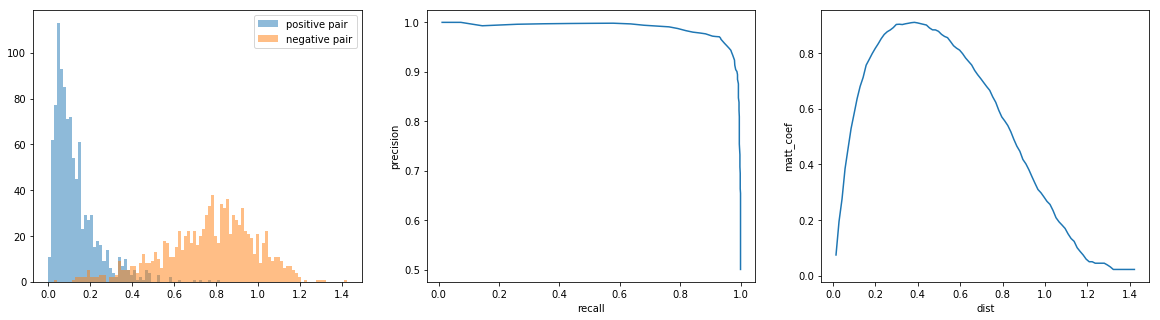

{1: 0.85866666666666669, 20: 0.98133333333333328, 5: 0.94099999999999995}
True
False
Epoch 1/10
100/100 [==============================] - 63s - loss: 3.7177    
Epoch 2/10
100/100 [==============================] - 59s - loss: 4.1250    
Epoch 3/10
100/100 [==============================] - 59s - loss: 4.6146    
Epoch 4/10
100/100 [==============================] - 59s - loss: 3.4154    
Epoch 5/10
100/100 [==============================] - 59s - loss: 6.4276    
Epoch 6/10
100/100 [==============================] - 59s - loss: 4.1292    
Epoch 7/10
100/100 [==============================] - 59s - loss: 2.6081    
Epoch 8/10
100/100 [==============================] - 59s - loss: 4.8441    
Epoch 9/10
100/100 [==============================] - 59s - loss: 3.7214    
Epoch 10/10
100/100 [==============================] - 59s - loss: 3.8971    
preprocess True
overlay False
train True
1000 19.5987188816
2000 39.1856689453
3000 58.8733198643
4000 78.4777889252
5000 98.07030797
6000 117.6

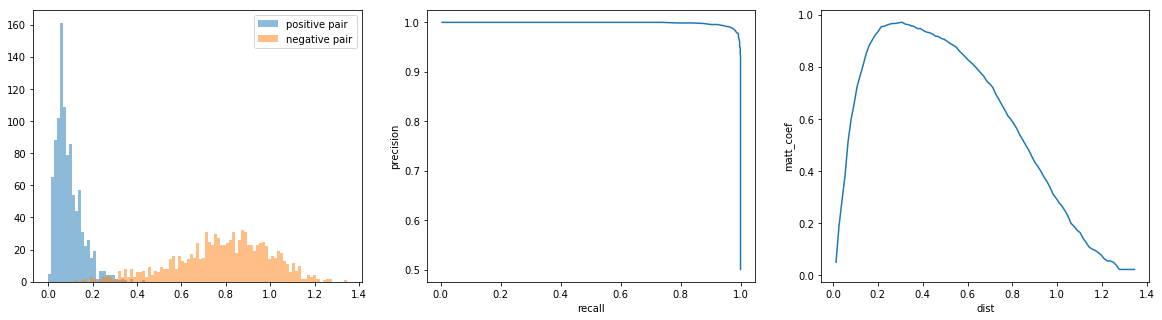

{1: 0.89800000000000002, 20: 0.99733333333333329, 5: 0.98233333333333339}
preprocess True
overlay False
train False
1000 19.5601627827
2000 39.0896070004
3000 58.6382169724
4000 78.1129579544
5000 97.5939199924
6000 117.109664917
7000 136.651490927
test 13000


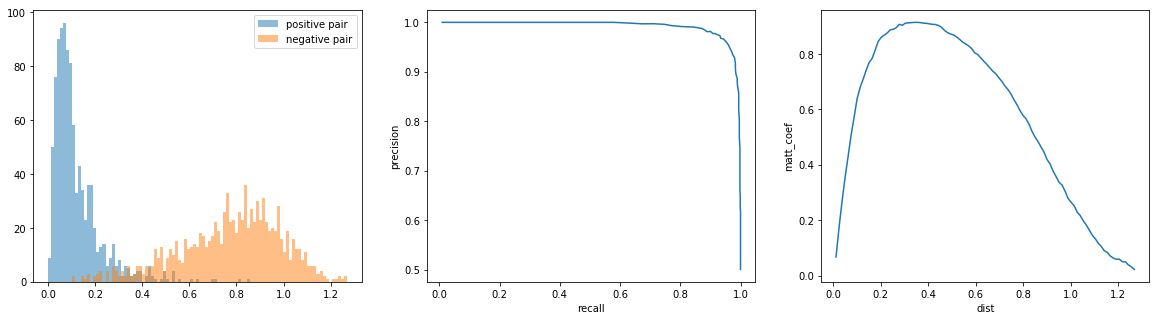

{1: 0.85033333333333339, 20: 0.98233333333333339, 5: 0.94866666666666666}
TrueEpoch 1/10

False
100/100 [==============================] - 62s - loss: 3.3368    
Epoch 2/10
100/100 [==============================] - 57s - loss: 3.3486    
Epoch 3/10
100/100 [==============================] - 58s - loss: 2.9130    
Epoch 4/10
100/100 [==============================] - 57s - loss: 4.2804    
Epoch 5/10
100/100 [==============================] - 58s - loss: 4.6630    
Epoch 6/10
100/100 [==============================] - 57s - loss: 4.9481    
Epoch 7/10
100/100 [==============================] - 57s - loss: 5.0036    
Epoch 8/10
100/100 [==============================] - 58s - loss: 4.1015    
Epoch 9/10
100/100 [==============================] - 57s - loss: 3.9489    
Epoch 10/10
100/100 [==============================] - 57s - loss: 5.6199    
preprocess True
overlay False
train True
1000 19.5540940762
2000 39.0813040733
3000 58.6489541531
4000 78.1809720993
5000 97.6880230904
6000 117

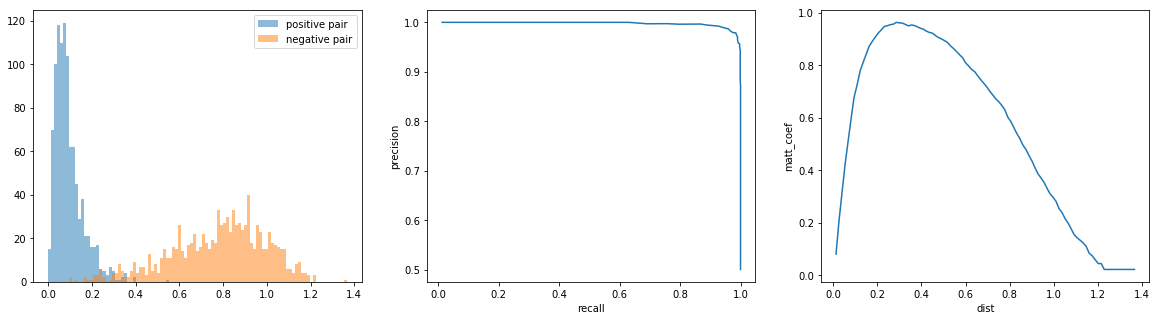

{1: 0.90466666666666662, 20: 0.99733333333333329, 5: 0.98433333333333328}
preprocess True
overlay False
train False
1000 19.5695869923
2000 39.1560981274
3000 58.6931891441
4000 78.2219450474
5000 97.7320160866
6000 117.252030134
7000 136.773734093
test 14000


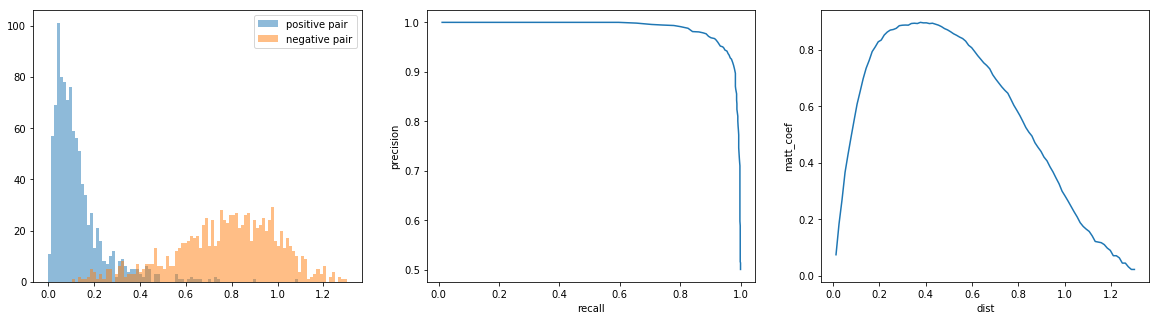

{1: 0.85099999999999998, 20: 0.97800000000000009, 5: 0.94766666666666666}
True
False
Epoch 1/10
100/100 [==============================] - 62s - loss: 2.6034    
Epoch 2/10
100/100 [==============================] - 57s - loss: 4.7518    
Epoch 3/10
100/100 [==============================] - 57s - loss: 5.9929    
Epoch 4/10
100/100 [==============================] - 57s - loss: 6.1902    
Epoch 5/10
100/100 [==============================] - 57s - loss: 3.3223    
Epoch 6/10
100/100 [==============================] - 58s - loss: 5.1675    
Epoch 7/10
100/100 [==============================] - 57s - loss: 5.9110    
Epoch 8/10
100/100 [==============================] - 57s - loss: 2.6161    
Epoch 9/10
100/100 [==============================] - 57s - loss: 3.3515    
Epoch 10/10
100/100 [==============================] - 57s - loss: 4.0236    
preprocess True
overlay False
train True
1000 19.5564739704
2000 39.1188640594
3000 58.6721100807
4000 78.2052989006
5000 97.7532510757
6000 117

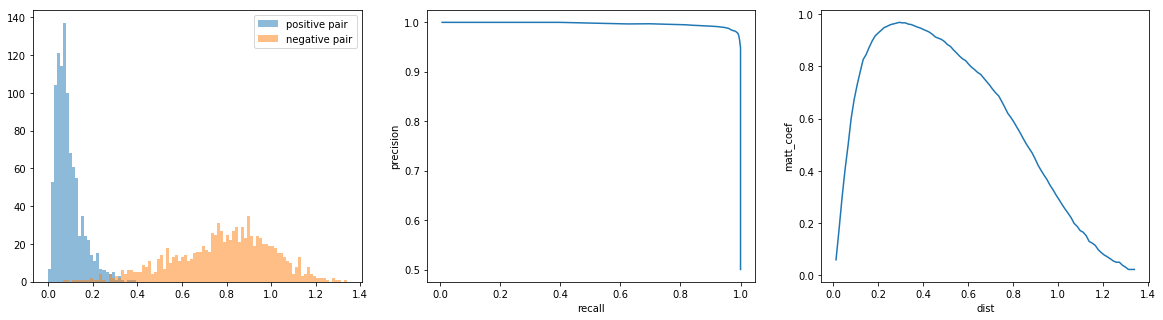

{1: 0.91299999999999992, 20: 0.99799999999999989, 5: 0.98433333333333328}
preprocess True
overlay False
train False
1000 19.5254919529
2000 39.1083359718
3000 58.6255850792
4000 78.1286420822
5000 97.6309230328
6000 117.145534992
7000 136.696424007
test 15000


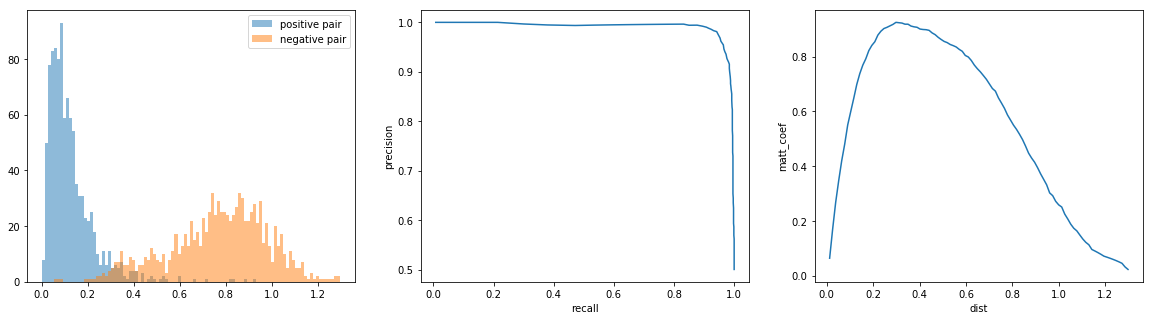

{1: 0.83799999999999997, 20: 0.97733333333333328, 5: 0.94299999999999995}


In [18]:
file_root = 'densenet_triplet_front_vanilla'

train_score = {}
test_score = {}

base_model = densenet.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3))

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

x = base_model.outputs[0]
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

trinet = Model(inputs=base_model.input, outputs=predictions)
trinet.compile(loss=triplet.triplet_loss, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

history = History()

for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(triplet.output_batch_generator(front_train_dict, front_train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score[iterations] = triplet.get_score(trinet, front_train_dict_2, front_train_files_2, hist=history, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                               shape=input_shape)
    print 'train' , iterations
    plot_score(train_score[iterations])

    test_score[iterations] = triplet.get_score(trinet, front_test_dict_2, front_test_files_2, hist=history, 
                                        overlay=overlay_eval, train=False, preprocess=preprocess, 
                                               shape=input_shape)
    print 'test', iterations
    plot_score(test_score[iterations])

In [19]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)

In [20]:
back_train_dict_2 = {}
back_train_files_2 = []

idt_at_least_2 = []

for idt in back_train_dict.keys():
    if len(back_train_dict[idt]) > 1:
        idt_at_least_2.append(idt)
        back_train_dict_2[idt] = back_train_dict[idt]

for f in back_train_files:
    try:
        x = idt_at_least_2.index(f[1])
        back_train_files_2.append(f)
    except ValueError:
        pass

In [21]:
back_test_dict_2 = {}
back_test_files_2 = []

idt_at_least_2_2 = []

for idt in back_test_dict.keys():
    if len(back_test_dict[idt]) > 1:
        idt_at_least_2_2.append(idt)
        back_test_dict_2[idt] = back_test_dict[idt]

for f in back_test_files:
    try:
        x = idt_at_least_2_2.index(f[1])
        back_test_files_2.append(f)
    except ValueError:
        pass

Weights for the model were loaded successfully
True
False
Epoch 1/10
100/100 [==============================] - 67s - loss: 213.0470    
Epoch 2/10
100/100 [==============================] - 66s - loss: 141.3166    
Epoch 3/10
100/100 [==============================] - 65s - loss: 116.6156    
Epoch 4/10
100/100 [==============================] - 65s - loss: 94.8090    
Epoch 5/10
100/100 [==============================] - 65s - loss: 77.0165    
Epoch 6/10
100/100 [==============================] - 65s - loss: 73.6472    
Epoch 7/10
100/100 [==============================] - 65s - loss: 78.3414    
Epoch 8/10
100/100 [==============================] - 66s - loss: 64.9722    
Epoch 9/10
100/100 [==============================] - 65s - loss: 63.4712    
Epoch 10/10
100/100 [==============================] - 65s - loss: 49.7578    
preprocess True
overlay False
train True
1000 21.9317679405
2000 42.1869039536
3000 62.4638500214
4000 82.7730579376
5000 103.046827078
train 1000


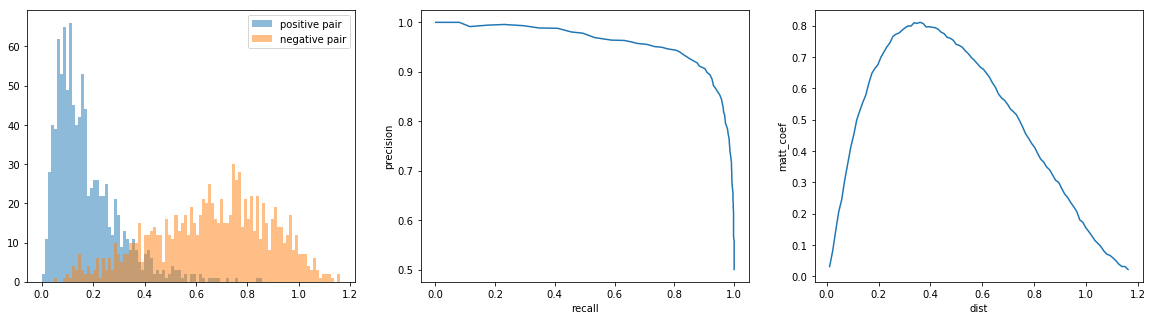

{1: 0.67833333333333334, 20: 0.92566666666666675, 5: 0.83333333333333337}
preprocess True
overlay False
train False
1000 20.3152241707
2000 40.6356360912
3000 60.9142091274
4000 81.1768000126
5000 101.438990116
test 1000


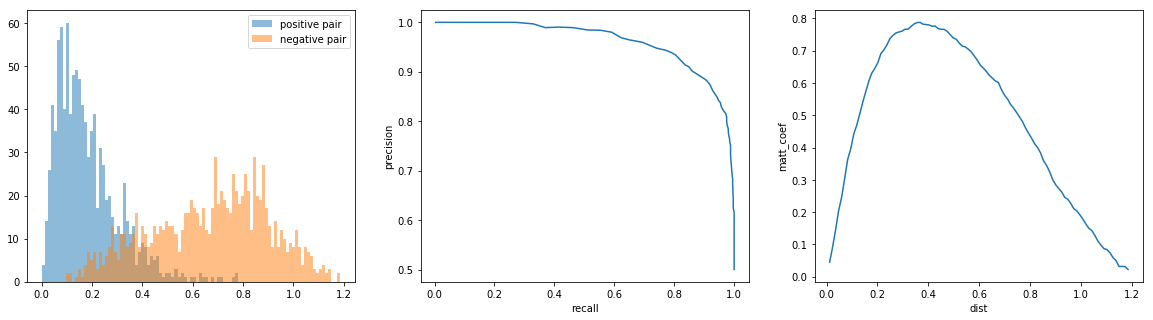

{1: 0.66000000000000003, 20: 0.92266666666666675, 5: 0.83933333333333326}
True
Epoch 1/10
False
100/100 [==============================] - 68s - loss: 53.0039    
Epoch 2/10
100/100 [==============================] - 64s - loss: 56.6394    
Epoch 3/10
100/100 [==============================] - 65s - loss: 44.1277    
Epoch 4/10
100/100 [==============================] - 65s - loss: 59.9140    
Epoch 5/10
100/100 [==============================] - 65s - loss: 53.7971    
Epoch 6/10
100/100 [==============================] - 65s - loss: 62.1784    
Epoch 7/10
100/100 [==============================] - 65s - loss: 55.0602    
Epoch 8/10
100/100 [==============================] - 65s - loss: 50.1668    
Epoch 9/10
100/100 [==============================] - 65s - loss: 46.4672    
Epoch 10/10
100/100 [==============================] - 66s - loss: 54.4241    
preprocess True
overlay False
train True
1000 20.2860431671
2000 40.6375889778
3000 60.9300301075
4000 81.2566421032
5000 101.60887599

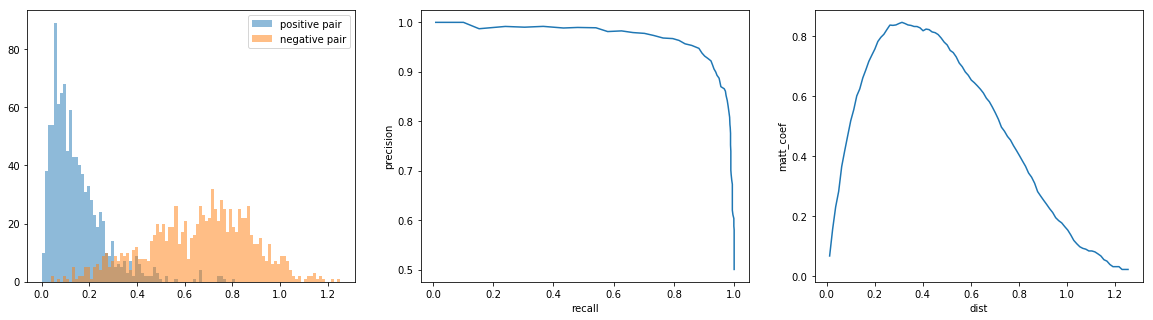

{1: 0.68400000000000005, 20: 0.94200000000000006, 5: 0.86299999999999999}
preprocess True
overlay False
train False
1000 20.3003189564
2000 40.6950478554
3000 60.9699840546
4000 81.2729299068
5000 101.594086885
test 2000


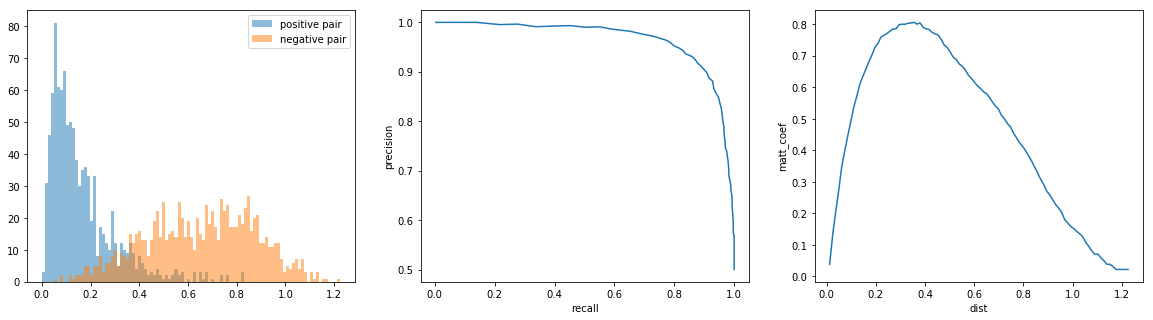

{1: 0.66066666666666674, 20: 0.93333333333333346, 5: 0.84033333333333327}
TrueEpoch 1/10

False
100/100 [==============================] - 69s - loss: 45.1525    
Epoch 2/10
100/100 [==============================] - 65s - loss: 43.0933    
Epoch 3/10
100/100 [==============================] - 65s - loss: 50.6610    
Epoch 4/10
100/100 [==============================] - 65s - loss: 62.7877    
Epoch 5/10
100/100 [==============================] - 65s - loss: 67.1985    
Epoch 6/10
100/100 [==============================] - 65s - loss: 60.4363    
Epoch 7/10
100/100 [==============================] - 66s - loss: 43.3748    
Epoch 8/10
100/100 [==============================] - 65s - loss: 41.7406    
Epoch 9/10
100/100 [==============================] - 65s - loss: 36.5291    
Epoch 10/10
100/100 [==============================] - 66s - loss: 41.5535    
preprocess True
overlay False
train True
1000 20.2563779354
2000 40.5187358856
3000 60.7842199802
4000 81.0588018894
5000 101.32436084

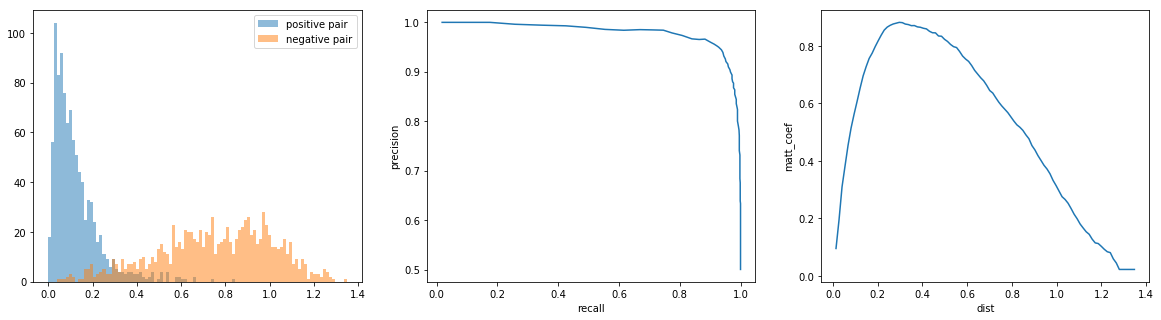

{1: 0.7403333333333334, 20: 0.96599999999999986, 5: 0.90366666666666662}
preprocess True
overlay False
train False
1000 20.2831919193
2000 40.5427539349
3000 60.8156988621
4000 81.1071629524
5000 101.415678978
test 3000


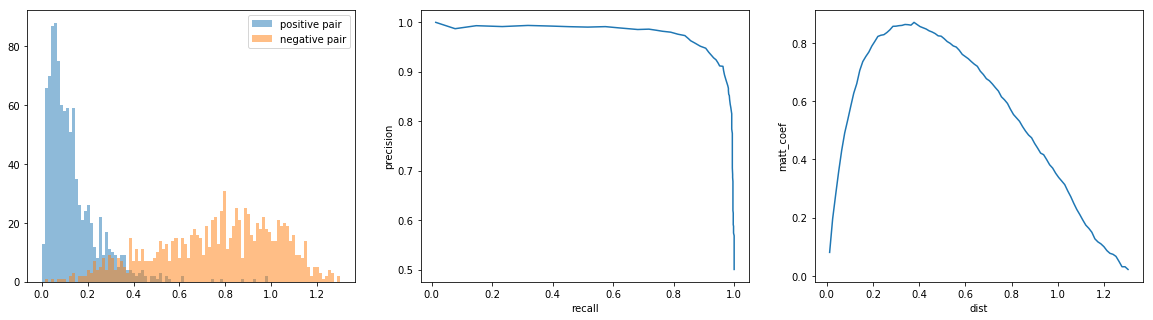

{1: 0.71566666666666656, 20: 0.95166666666666655, 5: 0.87166666666666659}True

FalseEpoch 1/10

100/100 [==============================] - 68s - loss: 28.4454    
Epoch 2/10
100/100 [==============================] - 66s - loss: 36.4188    
Epoch 3/10
100/100 [==============================] - 65s - loss: 37.4405    
Epoch 4/10
100/100 [==============================] - 65s - loss: 41.5323    
Epoch 5/10
100/100 [==============================] - 65s - loss: 45.3054    
Epoch 6/10
100/100 [==============================] - 65s - loss: 24.0299    
Epoch 7/10
100/100 [==============================] - 64s - loss: 43.2553    
Epoch 8/10
100/100 [==============================] - 65s - loss: 24.8296    
Epoch 9/10
100/100 [==============================] - 65s - loss: 36.4172    
Epoch 10/10
100/100 [==============================] - 65s - loss: 35.5248    
preprocess True
overlay False
train True
1000 20.2905769348
2000 40.5834670067
3000 60.8729159832
4000 81.2103238106
5000 101.48174381

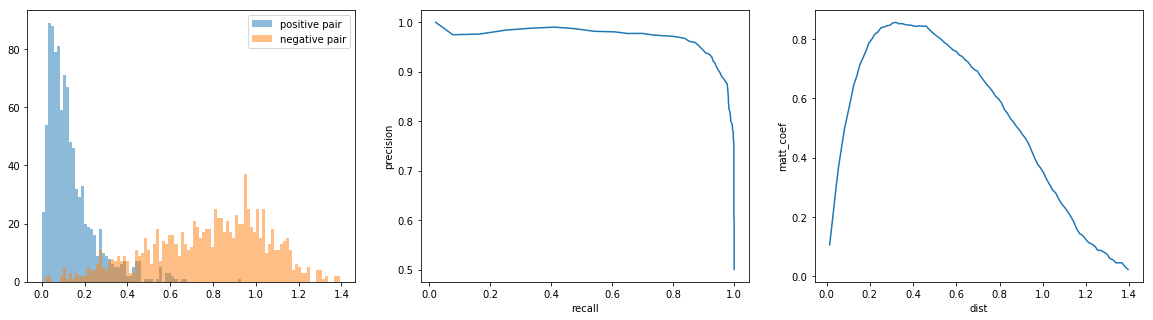

{1: 0.75200000000000011, 20: 0.96566666666666656, 5: 0.89699999999999991}
preprocess True
overlay False
train False
1000 20.3112840652
2000 40.6197831631
3000 60.9003310204
4000 81.1800210476
5000 101.474956989
test 4000


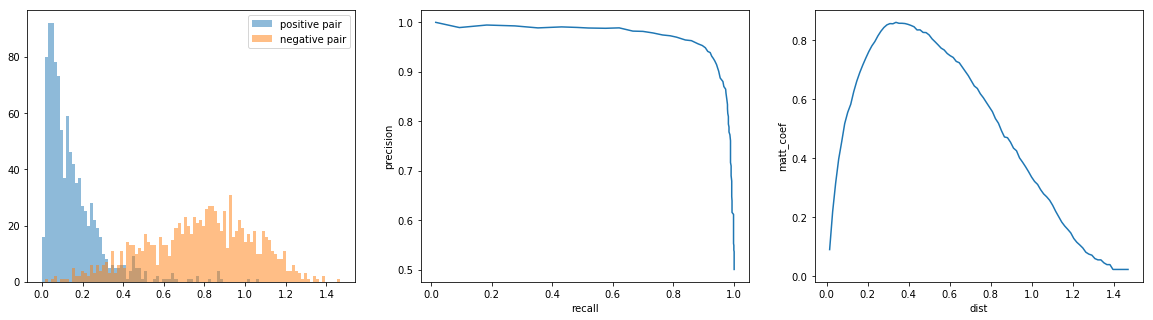

{1: 0.69799999999999995, 20: 0.94966666666666655, 5: 0.87766666666666671}
True
FalseEpoch 1/10

100/100 [==============================] - 68s - loss: 29.8830    
Epoch 2/10
100/100 [==============================] - 65s - loss: 39.6999    
Epoch 3/10
100/100 [==============================] - 65s - loss: 41.4519    
Epoch 4/10
100/100 [==============================] - 66s - loss: 52.2841    
Epoch 5/10
100/100 [==============================] - 65s - loss: 42.7412    
Epoch 6/10
100/100 [==============================] - 65s - loss: 36.7364    
Epoch 7/10
100/100 [==============================] - 64s - loss: 39.3951    
Epoch 8/10
100/100 [==============================] - 65s - loss: 32.5119    
Epoch 9/10
100/100 [==============================] - 65s - loss: 31.9381    
Epoch 10/10
100/100 [==============================] - 65s - loss: 36.4677    
preprocess True
overlay False
train True
1000 20.269423008
2000 40.5440039635
3000 60.8343408108
4000 81.0808269978
5000 101.305192947

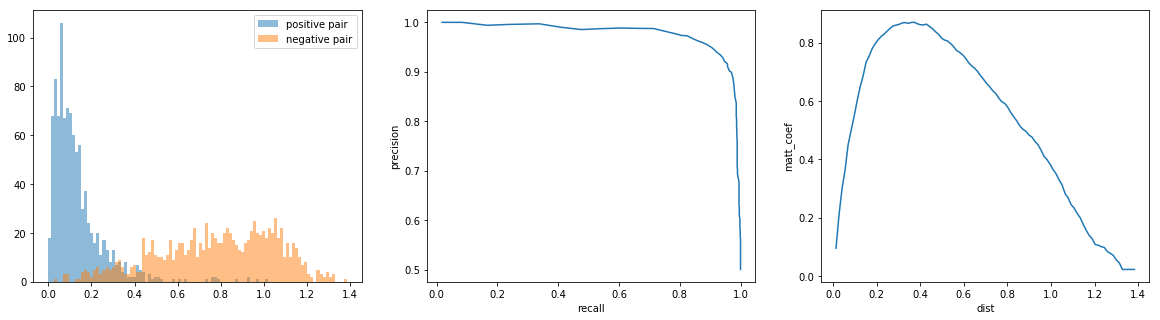

{1: 0.73533333333333328, 20: 0.95433333333333314, 5: 0.8876666666666666}
preprocess True
overlay False
train False
1000 20.2395448685
2000 40.4974508286
3000 60.8365359306
4000 81.1035590172
5000 101.390426874
test 5000


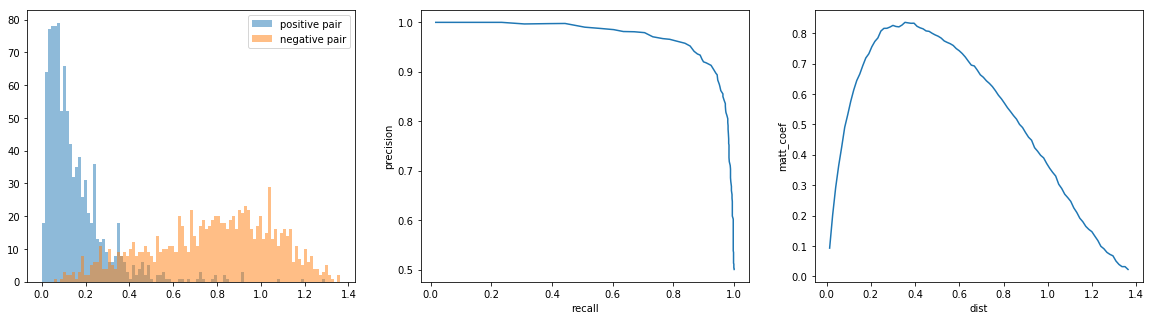

{1: 0.72166666666666668, 20: 0.94499999999999995, 5: 0.874}
TrueEpoch 1/10

False
100/100 [==============================] - 68s - loss: 35.6869    
Epoch 2/10
100/100 [==============================] - 64s - loss: 21.5028    
Epoch 3/10
100/100 [==============================] - 65s - loss: 14.9986    
Epoch 4/10
100/100 [==============================] - 65s - loss: 18.9132    
Epoch 5/10
100/100 [==============================] - 64s - loss: 14.6577    
Epoch 6/10
100/100 [==============================] - 65s - loss: 11.3686    
Epoch 7/10
100/100 [==============================] - 66s - loss: 13.0943    
Epoch 8/10
100/100 [==============================] - 65s - loss: 12.0949    
Epoch 9/10
100/100 [==============================] - 65s - loss: 6.7401    
Epoch 10/10
100/100 [==============================] - 65s - loss: 10.3990    
preprocess True
overlay False
train True
1000 20.3026640415
2000 40.5725150108
3000 60.8566250801
4000 81.1550490856
5000 101.408730984
train 6000


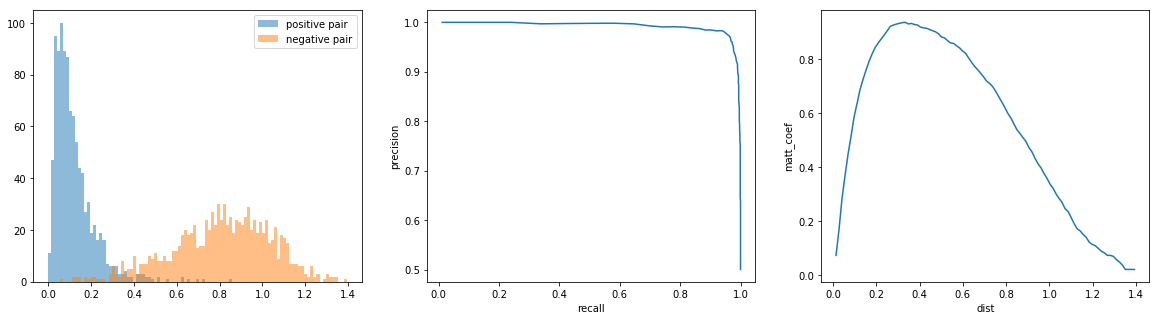

{1: 0.83866666666666667, 20: 0.98433333333333328, 5: 0.94899999999999995}
preprocess True
overlay False
train False
1000 20.2817049026
2000 40.5370330811
3000 60.8193950653
4000 81.1209580898
5000 101.402961016
test 6000


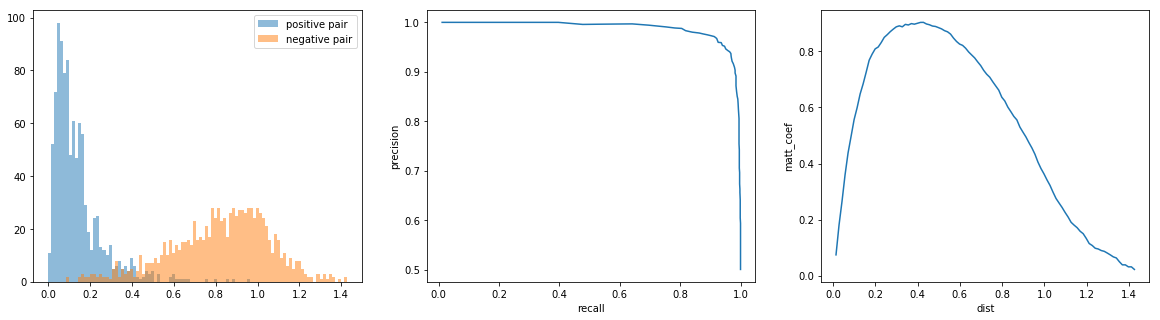

{1: 0.78733333333333333, 20: 0.96666666666666667, 5: 0.91100000000000003}
TrueEpoch 1/10

False
100/100 [==============================] - 68s - loss: 10.6867    
Epoch 2/10
100/100 [==============================] - 65s - loss: 7.3561    
Epoch 3/10
100/100 [==============================] - 65s - loss: 8.2937    
Epoch 4/10
100/100 [==============================] - 64s - loss: 6.8076    
Epoch 5/10
100/100 [==============================] - 65s - loss: 9.0411    
Epoch 6/10
100/100 [==============================] - 65s - loss: 7.0534    
Epoch 7/10
100/100 [==============================] - 65s - loss: 8.1634    
Epoch 8/10
100/100 [==============================] - 65s - loss: 9.3118    
Epoch 9/10
100/100 [==============================] - 65s - loss: 8.6563    
Epoch 10/10
100/100 [==============================] - 65s - loss: 5.1179    
preprocess True
overlay False
train True
1000 20.2773067951
2000 40.5789608955
3000 60.8513138294
4000 81.1212649345
5000 101.488405943
train 7

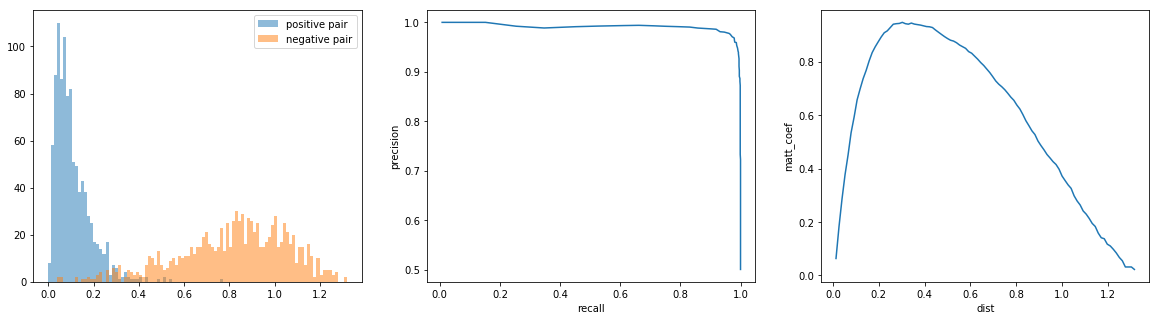

{1: 0.86033333333333328, 20: 0.98899999999999988, 5: 0.95599999999999996}
preprocess True
overlay False
train False
1000 20.3050429821
2000 40.602025032
3000 60.9074020386
4000 81.1799809933
5000 101.488200903
test 7000


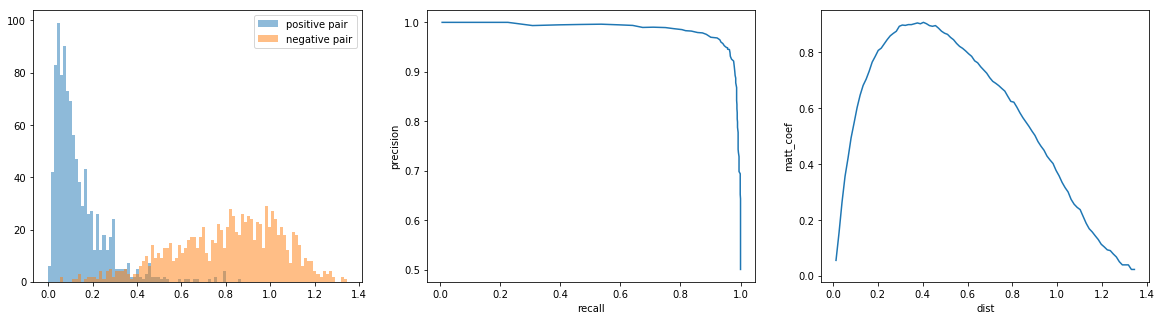

{1: 0.80433333333333346, 20: 0.97533333333333327, 5: 0.92300000000000004}
True
FalseEpoch 1/10

100/100 [==============================] - 68s - loss: 5.2291    
Epoch 2/10
100/100 [==============================] - 65s - loss: 7.6101    
Epoch 3/10
100/100 [==============================] - 65s - loss: 4.7427    
Epoch 4/10
100/100 [==============================] - 66s - loss: 6.1270    
Epoch 5/10
100/100 [==============================] - 65s - loss: 7.8389    
Epoch 6/10
100/100 [==============================] - 65s - loss: 6.7352    
Epoch 7/10
100/100 [==============================] - 65s - loss: 5.6305    
Epoch 8/10
100/100 [==============================] - 65s - loss: 4.2624    
Epoch 9/10
100/100 [==============================] - 65s - loss: 5.1069    
Epoch 10/10
100/100 [==============================] - 65s - loss: 9.9654     
preprocess True
overlay False
train True
1000 20.2760210037
2000 40.5599429607
3000 60.8879439831
4000 81.1349470615
5000 101.431935072
train 8

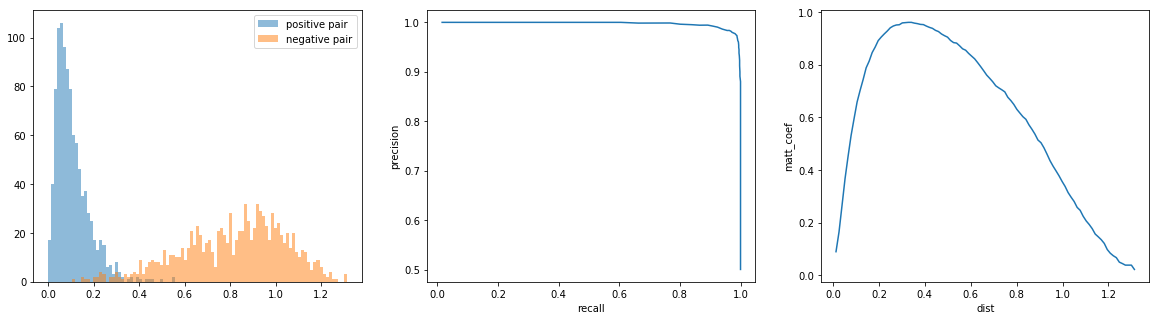

{1: 0.875, 20: 0.99400000000000011, 5: 0.97000000000000008}
preprocess True
overlay False
train False
1000 20.339851141
2000 40.6410331726
3000 60.9047889709
4000 81.1818511486
5000 101.489464045
test 8000


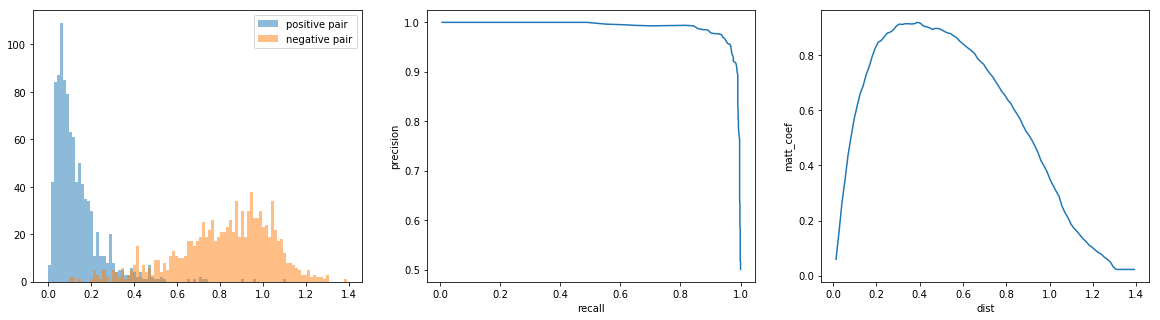

{1: 0.79700000000000004, 20: 0.97833333333333339, 5: 0.93266666666666664}True

False
Epoch 1/10
100/100 [==============================] - 68s - loss: 3.5583    
Epoch 2/10
100/100 [==============================] - 65s - loss: 4.1946    
Epoch 3/10
100/100 [==============================] - 65s - loss: 7.7656    
Epoch 4/10
100/100 [==============================] - 65s - loss: 6.3893    
Epoch 5/10
100/100 [==============================] - 65s - loss: 5.3820    
Epoch 6/10
100/100 [==============================] - 65s - loss: 4.1041    
Epoch 7/10
100/100 [==============================] - 66s - loss: 3.3668    
Epoch 8/10
100/100 [==============================] - 65s - loss: 6.7274    
Epoch 9/10
100/100 [==============================] - 65s - loss: 7.7817    
Epoch 10/10
100/100 [==============================] - 66s - loss: 6.8179    
preprocess True
overlay False
train True
1000 20.2995109558
2000 40.5593378544
3000 60.7986388206
4000 81.0705189705
5000 101.372163773
train 90

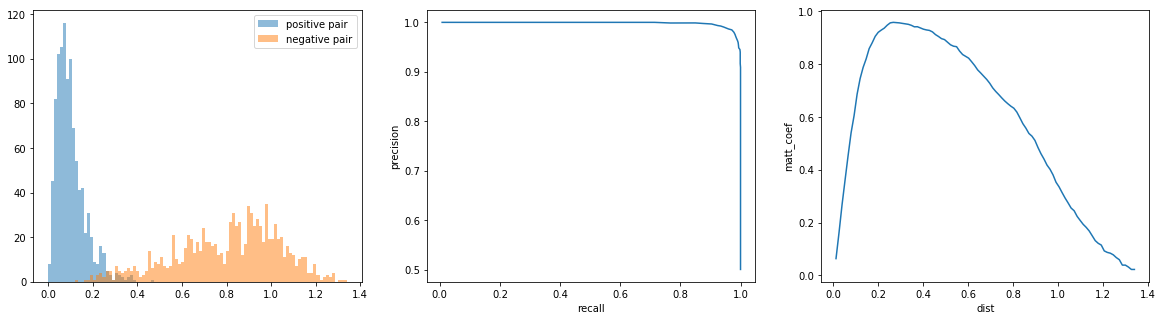

{1: 0.89600000000000002, 20: 0.995, 5: 0.97366666666666657}
preprocess True
overlay False
train False
1000 20.2601358891
2000 40.5514450073
3000 60.8559849262
4000 81.1363909245
5000 101.427322865
test 9000


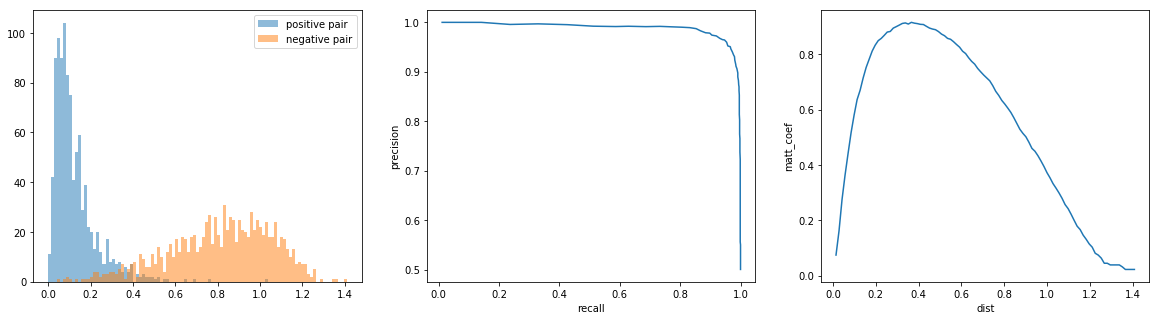

{1: 0.81766666666666665, 20: 0.97833333333333339, 5: 0.94166666666666676}
True
False
Epoch 1/10
100/100 [==============================] - 68s - loss: 6.0041    
Epoch 2/10
100/100 [==============================] - 65s - loss: 2.7446    
Epoch 3/10
100/100 [==============================] - 65s - loss: 2.1784    
Epoch 4/10
100/100 [==============================] - 65s - loss: 7.2569    
Epoch 5/10
100/100 [==============================] - 65s - loss: 5.3018    
Epoch 6/10
100/100 [==============================] - 65s - loss: 6.6781    
Epoch 7/10
100/100 [==============================] - 65s - loss: 2.6188    
Epoch 8/10
100/100 [==============================] - 66s - loss: 4.2826    
Epoch 9/10
100/100 [==============================] - 64s - loss: 5.1992    
Epoch 10/10
100/100 [==============================] - 65s - loss: 5.2508    
preprocess True
overlay False
train True
1000 20.2575068474
2000 40.5143289566
3000 60.7709817886
4000 81.047976017
5000 101.333948851
train 100

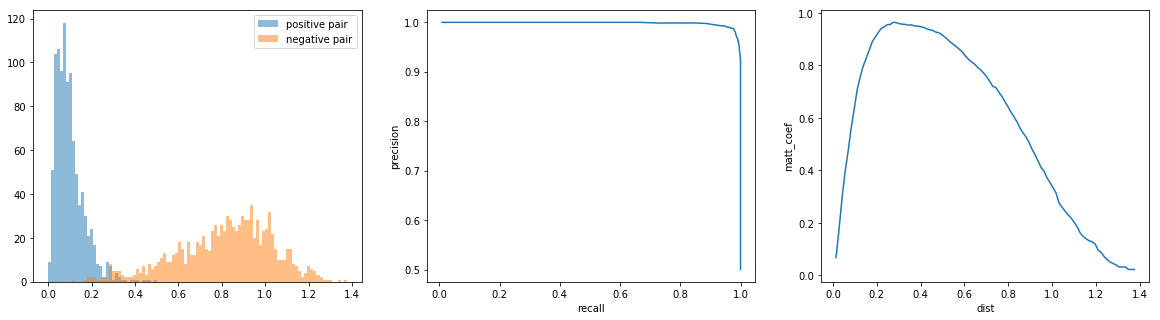

{1: 0.90433333333333332, 20: 0.9966666666666667, 5: 0.97800000000000009}
preprocess True
overlay False
train False
1000 20.2769520283
2000 40.5849130154
3000 60.9161939621
4000 81.1532611847
5000 101.444481134
test 10000


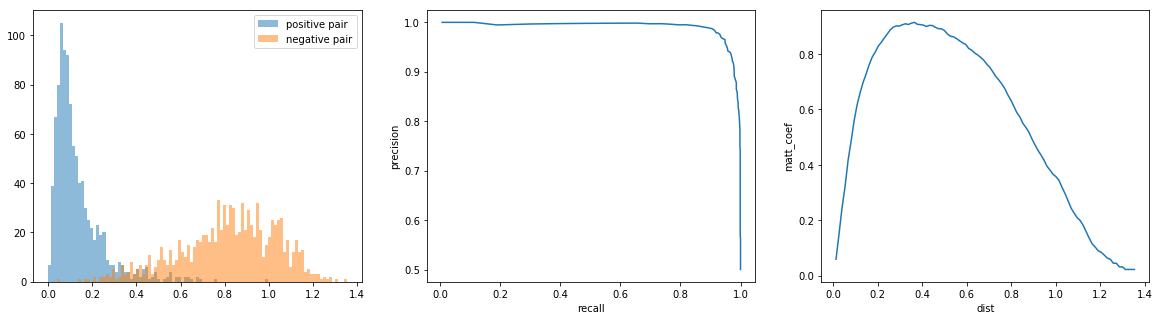

{1: 0.81566666666666665, 20: 0.97833333333333339, 5: 0.93733333333333324}
True
Epoch 1/10False

100/100 [==============================] - 68s - loss: 3.9584    
Epoch 2/10
100/100 [==============================] - 64s - loss: 5.2961    
Epoch 3/10
100/100 [==============================] - 65s - loss: 4.0628    
Epoch 4/10
100/100 [==============================] - 65s - loss: 4.9874    
Epoch 5/10
100/100 [==============================] - 64s - loss: 6.2980    
Epoch 6/10
100/100 [==============================] - 65s - loss: 4.8599    
Epoch 7/10
100/100 [==============================] - 64s - loss: 2.6786    
Epoch 8/10
100/100 [==============================] - 65s - loss: 3.2273    
Epoch 9/10
100/100 [==============================] - 65s - loss: 2.6606    
Epoch 10/10
100/100 [==============================] - 65s - loss: 5.4290    
preprocess True
overlay False
train True
1000 20.3404989243
2000 40.6622071266
3000 60.9727780819
4000 81.2711060047
5000 101.580323935
train 11

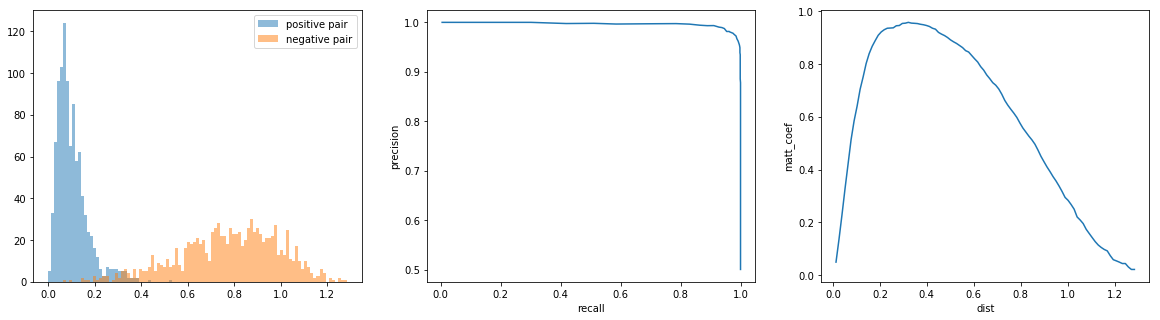

{1: 0.90366666666666662, 20: 0.9966666666666667, 5: 0.97933333333333328}
preprocess True
overlay False
train False
1000 20.316245079
2000 40.662525177
3000 60.9464731216
4000 81.1835560799
5000 101.440350056
test 11000


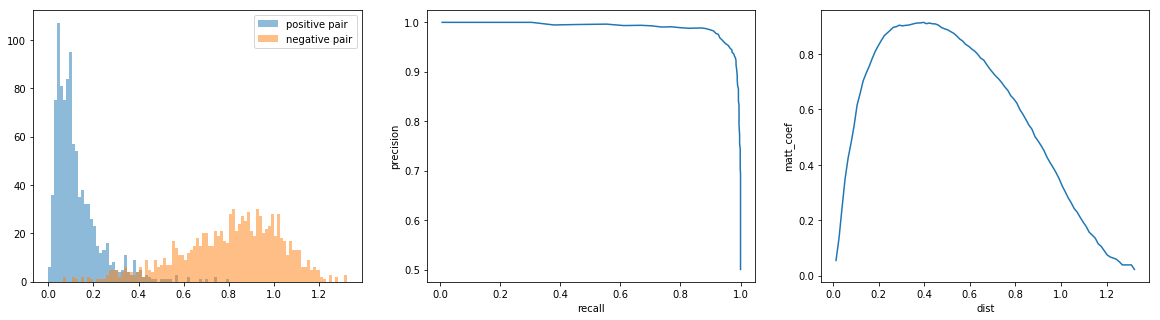

{1: 0.82933333333333337, 20: 0.97899999999999998, 5: 0.93866666666666665}
Epoch 1/10
True
False
100/100 [==============================] - 69s - loss: 5.0509    
Epoch 2/10
100/100 [==============================] - 66s - loss: 4.0639    
Epoch 3/10
100/100 [==============================] - 65s - loss: 4.2353    
Epoch 4/10
100/100 [==============================] - 66s - loss: 4.6825    
Epoch 5/10
100/100 [==============================] - 65s - loss: 5.6731    
Epoch 6/10
100/100 [==============================] - 66s - loss: 4.7847    
Epoch 7/10
100/100 [==============================] - 66s - loss: 5.3624    
Epoch 8/10
100/100 [==============================] - 65s - loss: 4.1656    
Epoch 9/10
100/100 [==============================] - 65s - loss: 3.8415    
Epoch 10/10
100/100 [==============================] - 65s - loss: 3.0292    
preprocess True
overlay False
train True
1000 20.4232730865
2000 40.7434859276
3000 61.0699319839
4000 81.3757879734
5000 101.688379049
train 12

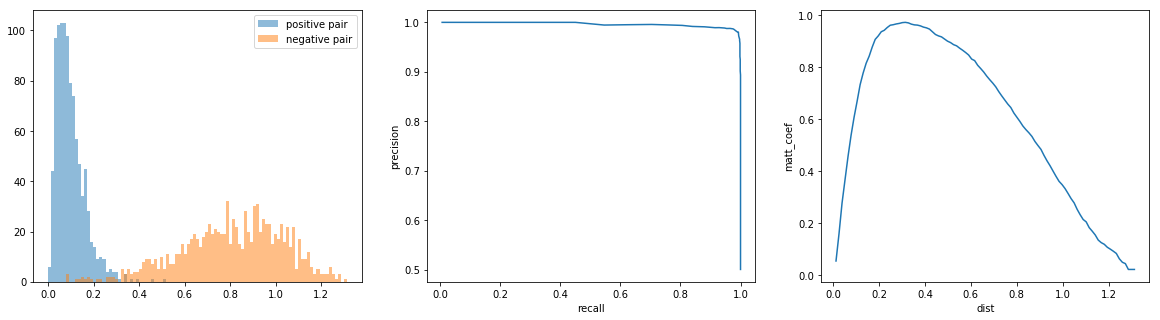

{1: 0.90533333333333343, 20: 0.99800000000000011, 5: 0.97966666666666669}
preprocess True
overlay False
train False
1000 20.2548279762
2000 40.5355908871
3000 60.824131012
4000 81.100538969
5000 101.482906818
test 12000


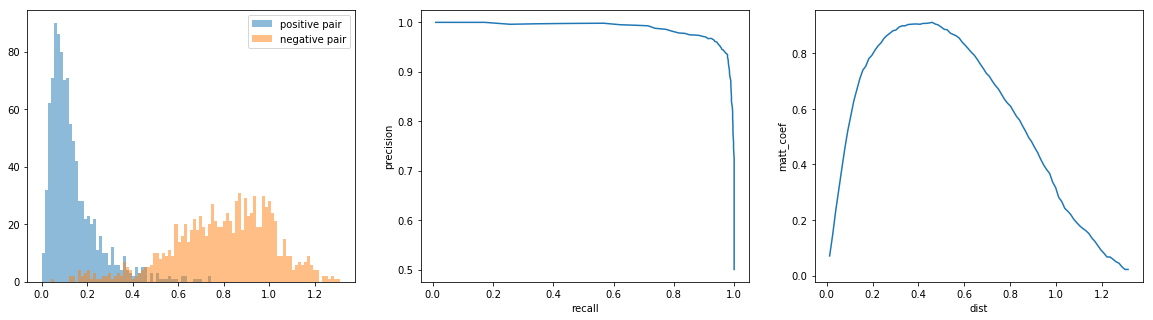

{1: 0.83066666666666666, 20: 0.98233333333333339, 5: 0.94066666666666665}
Epoch 1/10
True
False
100/100 [==============================] - 68s - loss: 3.3870    
Epoch 2/10
100/100 [==============================] - 67s - loss: 3.9046    
Epoch 3/10
100/100 [==============================] - 65s - loss: 5.7661    
Epoch 4/10
100/100 [==============================] - 65s - loss: 2.6687    
Epoch 5/10
100/100 [==============================] - 65s - loss: 4.6537    
Epoch 6/10
100/100 [==============================] - 65s - loss: 3.8402    
Epoch 7/10
100/100 [==============================] - 65s - loss: 3.6238    
Epoch 8/10
100/100 [==============================] - 66s - loss: 3.3171    
Epoch 9/10
100/100 [==============================] - 65s - loss: 4.8803    
Epoch 10/10
100/100 [==============================] - 65s - loss: 3.1579    
preprocess True
overlay False
train True
1000 20.3615238667
2000 40.6857550144
3000 61.0075778961
4000 81.2371380329
5000 101.521762848
train 13

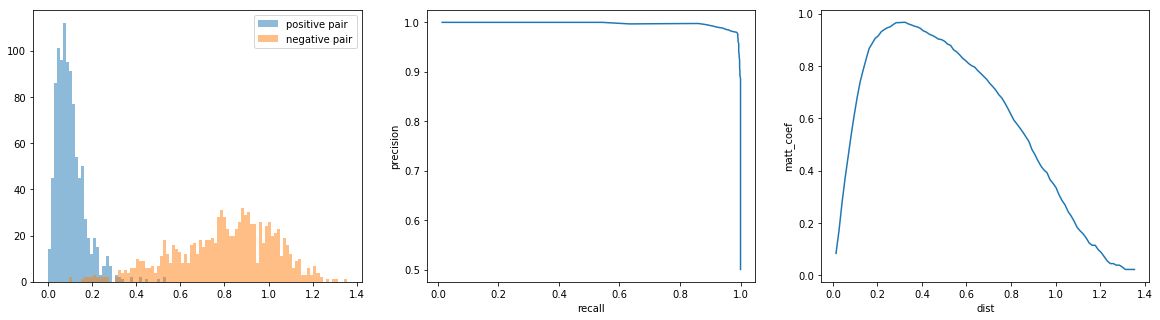

{1: 0.89400000000000002, 20: 0.996, 5: 0.97966666666666669}
preprocess True
overlay False
train False
1000 20.3355088234
2000 40.6046519279
3000 61.1164498329
4000 81.4202508926
5000 101.669685841
test 13000


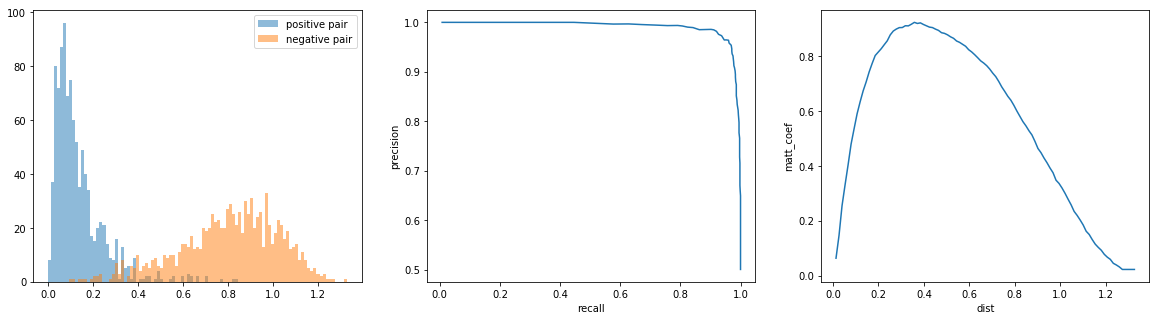

{1: 0.84099999999999986, 20: 0.97733333333333328, 5: 0.94333333333333325}True

False
Epoch 1/10
100/100 [==============================] - 68s - loss: 2.7395    
Epoch 2/10
100/100 [==============================] - 64s - loss: 2.7719    
Epoch 3/10
100/100 [==============================] - 65s - loss: 3.4741    
Epoch 4/10
100/100 [==============================] - 65s - loss: 3.4329    
Epoch 5/10
100/100 [==============================] - 66s - loss: 3.8512    
Epoch 6/10
100/100 [==============================] - 66s - loss: 4.4721    
Epoch 7/10
100/100 [==============================] - 65s - loss: 4.8337    
Epoch 8/10
100/100 [==============================] - 67s - loss: 4.1960    
Epoch 9/10
100/100 [==============================] - 67s - loss: 3.7133    
Epoch 10/10
100/100 [==============================] - 66s - loss: 3.0846    
preprocess True
overlay False
train True
1000 20.3640918732
2000 40.7239990234
3000 61.2152769566
4000 81.8368389606
5000 102.121817827
train 14

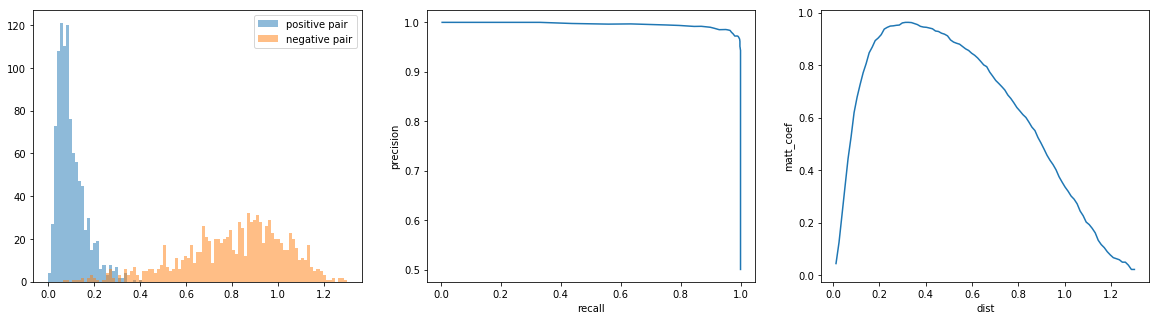

{1: 0.90600000000000003, 20: 0.996, 5: 0.98499999999999999}
preprocess True
overlay False
train False
1000 20.3585000038
2000 40.65528512
3000 60.9091889858
4000 81.1569690704
5000 101.439681053
test 14000


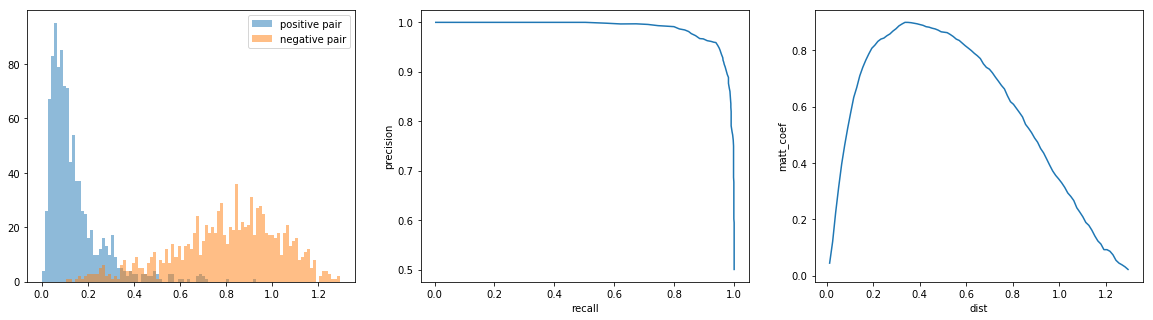

{1: 0.84099999999999986, 20: 0.97866666666666668, 5: 0.94733333333333325}
True
False
Epoch 1/10
100/100 [==============================] - 70s - loss: 3.8007    
Epoch 2/10
100/100 [==============================] - 65s - loss: 3.1847    
Epoch 3/10
100/100 [==============================] - 65s - loss: 3.2259    
Epoch 4/10
100/100 [==============================] - 65s - loss: 7.0838    
Epoch 5/10
100/100 [==============================] - 64s - loss: 2.5598    
Epoch 6/10
100/100 [==============================] - 65s - loss: 2.9791    
Epoch 7/10
100/100 [==============================] - 65s - loss: 2.1023    
Epoch 8/10
100/100 [==============================] - 65s - loss: 5.1455    
Epoch 9/10
100/100 [==============================] - 65s - loss: 3.8219    
Epoch 10/10
100/100 [==============================] - 65s - loss: 3.2661    
preprocess True
overlay False
train True
1000 20.2918710709
2000 40.6042449474
3000 60.8617868423
4000 81.2027709484
5000 101.427625895
train 15

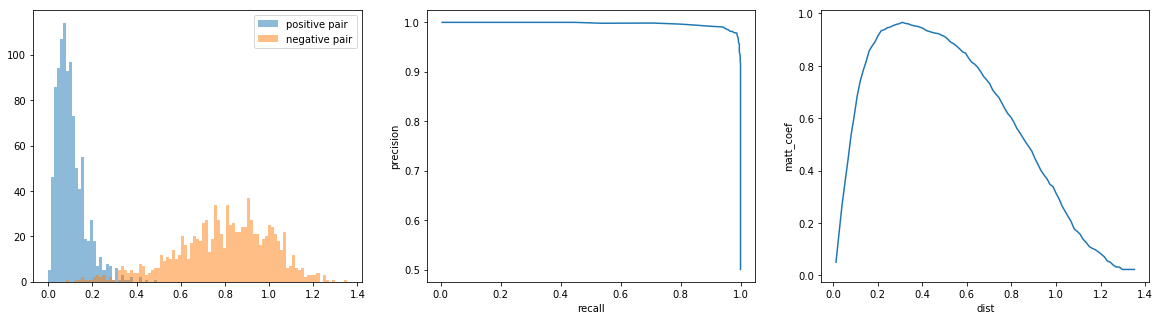

{1: 0.89966666666666673, 20: 0.99733333333333329, 5: 0.97999999999999998}
preprocess True
overlay False
train False
1000 20.2654509544
2000 40.552038908
3000 60.7778019905
4000 81.0337669849
5000 101.275539875
test 15000


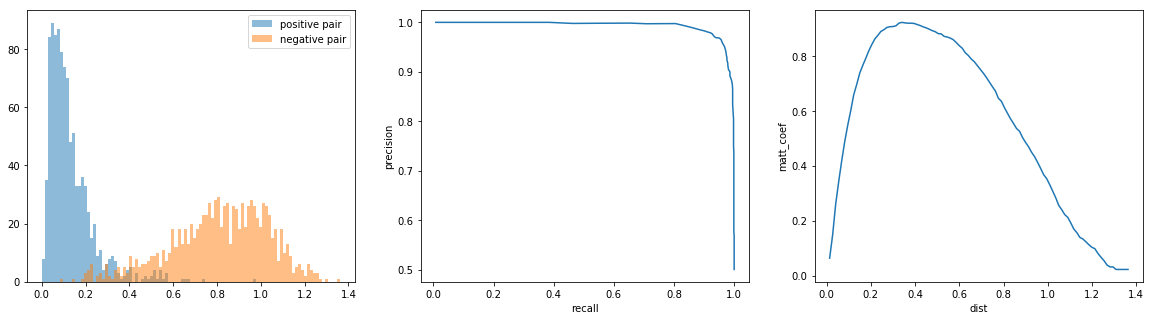

{1: 0.82433333333333325, 20: 0.98266666666666669, 5: 0.94399999999999995}


In [22]:
file_root = 'densenet_triplet_back_vanilla'

train_score = {}
test_score = {}

base_model = densenet.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3))

base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

x = base_model.outputs[0]
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128)(x)

trinet = Model(inputs=base_model.input, outputs=predictions)
trinet.compile(loss=triplet.triplet_loss, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

history = History()

for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(triplet.output_batch_generator(back_train_dict, back_train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
    train_score[iterations] = triplet.get_score(trinet, back_train_dict_2, back_train_files_2, hist=history, 
                                        overlay=overlay_eval, train=True, preprocess=preprocess, 
                                               shape=input_shape)
    print 'train' , iterations
    plot_score(train_score[iterations])

    test_score[iterations] = triplet.get_score(trinet, back_test_dict_2, back_test_files_2, hist=history, 
                                        overlay=overlay_eval, train=False, preprocess=preprocess, 
                                               shape=input_shape)
    print 'test', iterations
    plot_score(test_score[iterations])

In [23]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)